#### Human Kras data from our Cell Stem Cell paper

Data from Dost, Moye...Kim, 2020 Cell Stem Cell
Samples of two patients with the diagnosis stage IA LUAD were analyzed in these studies. One patient was female, 74 years old, with
a KRAS-G12F mutation identified as driver mutation. The other patient was female, 77 years old, with a KRAS-G12V mutation identified as driver mutation. All patients provided written informed consent. The studies were approved by the UCLA institutional review board.

In [3]:
import os
import glob
import scanpy as sc
import scanpy.external as sce
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from seaborn import despine
from seaborn import axes_style
import magic # imputation tool; van Dijk et al 2018 # 
from matplotlib.pyplot import suptitle
import matplotlib.colors
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch # for clustermap legends
import time

sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 7.2.0
backcall            0.1.0
cairo               1.19.1
cffi                1.14.0
colorama            0.4.5
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
decorator           4.4.2
deprecated          1.2.7
future              0.18.2
graphtools          1.5.0
h5py                3.7.0
igraph              0.8.2
ipykernel           5.2.0
ipython_genutils    0.2.0
ipywidgets          7.5.1
jedi                0.16.0
joblib              0.14.1
kiwisolver          1.1.0
leidenalg           0.7.0
llvmlite            0.31.0
louvain             0.6.1
magic               2.0.3
matplotlib          3.5.2
mpl_toolkits        NA
natsort             7.0.1
numba               0.48.0
numexpr             2.7.1
numpy               1.22.4
packaging           20.3
pandas              1.5.3
parso               0.6.2
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit   

In [87]:
filenames=[
    'path/to/h5ad_files',
    'path/to/h5ad_files',
    .......
]

adatas = [sc.read_10x_mtx(filename) for filename in filenames]

adata = adatas[0].concatenate(
    adatas[1:], 
    batch_categories = ['Case2_control', 'Case2_adeno', 'Case3_control', 'Case3_adeno']
                             ) # merge files into anndata object

adata.var_names_make_unique() # make gene names unique

... storing 'feature_types' as categorical
/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/scanpy/plotting/_utils.py:312: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


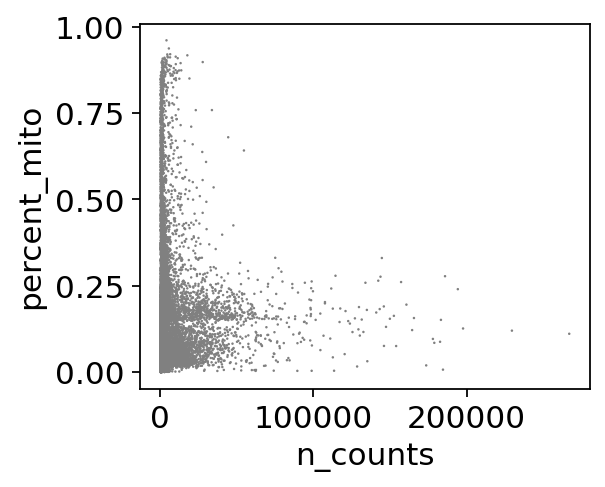

In [88]:
# compute %mito and remove cells with >10%
mito_genes = adata.var_names.str.startswith('MT-')

# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

rcParams['figure.figsize']=4,3
with axes_style({'axes.grid': False}):
 sc.pl.scatter(adata, y='percent_mito', x='n_counts', size=5)

#### Filtering and batch correction

In [89]:
'''
Filter normalize, and log the data
'''
adata = adata[adata.obs['percent_mito'] < 0.20, :]
adata = adata[adata.obs['n_counts'] < 80000, :]
adata = adata[adata.obs['n_counts'] > 200, :]
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_genes(adata, min_counts=1)

sc.pp.normalize_per_cell(adata) # library size normalize
sc.pp.log1p(adata)
adata.raw = adata

'''
Annotate the data based on its library of origin
'''

scores = adata.obs[['batch']]
annotation = pd.Series('Unknown', index=scores.index)
annotation[(scores.batch == 'Case2_control')|(scores.batch == 'Case2_adeno')] = 'Case2'  
annotation[(scores.batch == 'Case3_control')|(scores.batch == 'Case3_adeno')] = 'Case3' 
adata.obs['case'] = annotation

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'case')

print("Highly variable genes intersection: %d"%sum(adata.var.highly_variable_intersection))
print("Number of batches where gene is variable:")
print(adata.var.highly_variable_nbatches.value_counts())
var_genes_batch = adata.var.highly_variable_nbatches > 0

print("Any batch var genes: %d"%sum(var_genes_batch))
print("Variable genes in all batches: %d"%sum(adata.var.highly_variable_nbatches == 2))

# use hvg common in both cases
var_select = adata.var.highly_variable_nbatches == 2
var_genes = var_select.index[var_select]
len(var_genes)

batches = ['Case2', 'Case3']
alldata = {}
for batch in batches:
    alldata[batch] = adata[adata.obs['case'] == batch,]

alldata

alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes]

#convert to list of AnnData objects
adatas = list(alldata2.values())

Trying to set attribute `.var` of view, copying.
... storing 'case' as categorical


Highly variable genes intersection: 1881
Number of batches where gene is variable:
0    15202
1     5510
2     1881
Name: highly_variable_nbatches, dtype: int64
Any batch var genes: 7391
Variable genes in all batches: 1881
Case2
Case3


In [90]:
import scanorama # batch correction

# run scanorama.integrate
scanorama  = scanorama.integrate_scanpy(adatas, dimred = 50,)

# returns a list of 2 np.ndarrays with 50 columns.
print(scanorama[0].shape)
print(scanorama[1].shape)

# make into one matrix.
all_s = np.concatenate(scanorama)
print(all_s.shape)

# add to the AnnData object
adata.obsm["SC"] = all_s

Found 1881 genes among all datasets
[[0.         0.77633851]
 [0.         0.        ]]
Processing datasets (0, 1)
(5687, 50)
(3474, 50)
(9161, 50)


#### Data denoising (MAGIC)

Performing MAGIC
  Running MAGIC with `solver='exact'` on 22593-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


  Running MAGIC with `solver='exact'` on 22593-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


  Running MAGIC with `solver='exact'` on 22593-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


Plotting data
Total run time (min): 3.6492769996325176


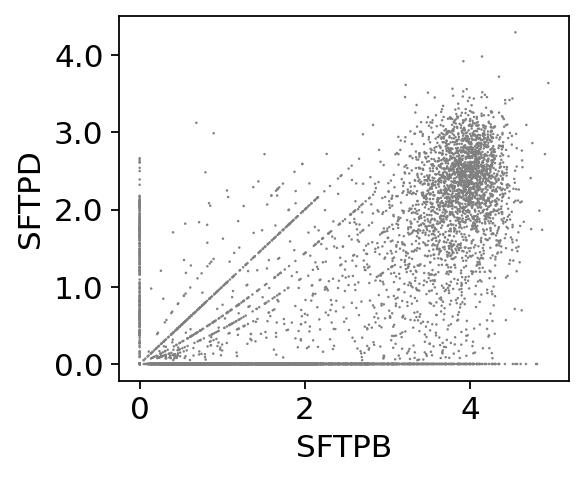

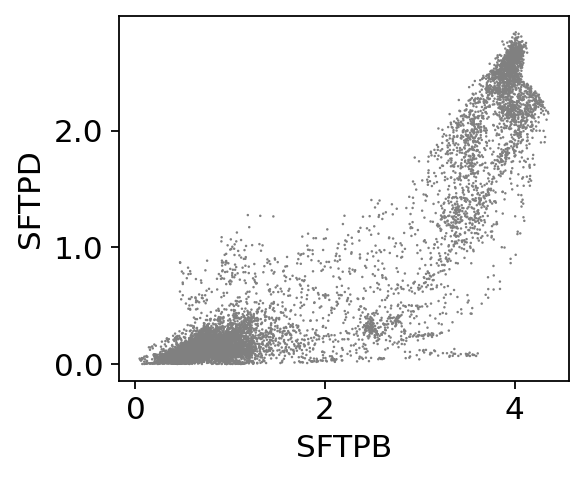

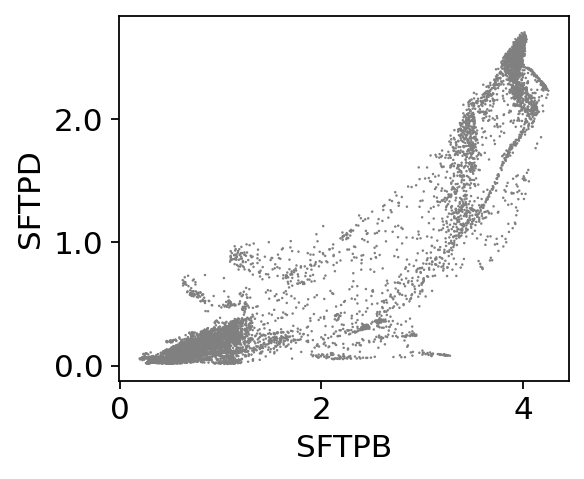

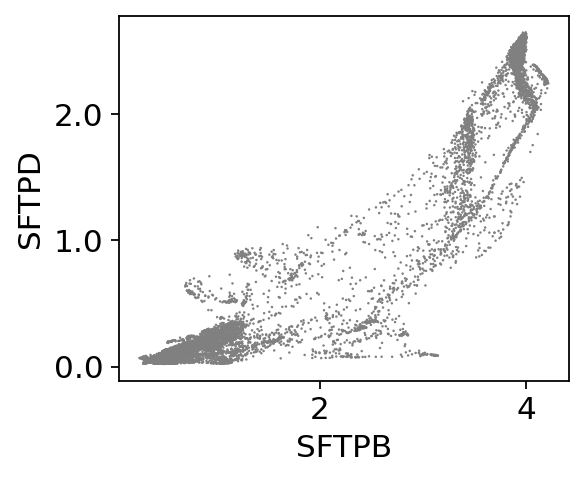

In [91]:
''''''''' Visulize effect of imputation at different t values '''''''''

start = time.time()

# seperate adatas
adata2 = adata.copy()
adata5 = adata.copy()
adata7 = adata.copy()

# impute
print('Performing MAGIC')
sce.pp.magic(adata2, name_list='all_genes', knn=5, t=2, n_pca=20)
sce.pp.magic(adata5, name_list='all_genes', knn=5, t=5, n_pca=20)
sce.pp.magic(adata7, name_list='all_genes', knn=5, t=7, n_pca=20)

# plot sftpc-lyz2 correlation after different imputation t values 
adata_list = [adata, adata2, adata5, adata7]
print('Plotting data')
    
for i in adata_list:
    with axes_style({'axes.grid': False}):
        ax = sc.pl.scatter(i, x='SFTPB', y='SFTPD', size=5, use_raw=False, show=False)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
end = time.time()
print('Total run time (min):', (end - start)/60)

In [92]:
# Use optimal t value to impute the data post batch correction

sce.pp.magic(adata, name_list='all_genes', knn=5, t=5, n_pca=20)

# Scanorama creates a PCA embedding so there is no need to calculate PCA again
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=20, use_rep='SC')
sc.tl.umap(adata)

  Running MAGIC with `solver='exact'` on 22593-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):
/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/numba/typed_passes.py:292: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/umap/spectral.py:227: UserWarning: Embedding 

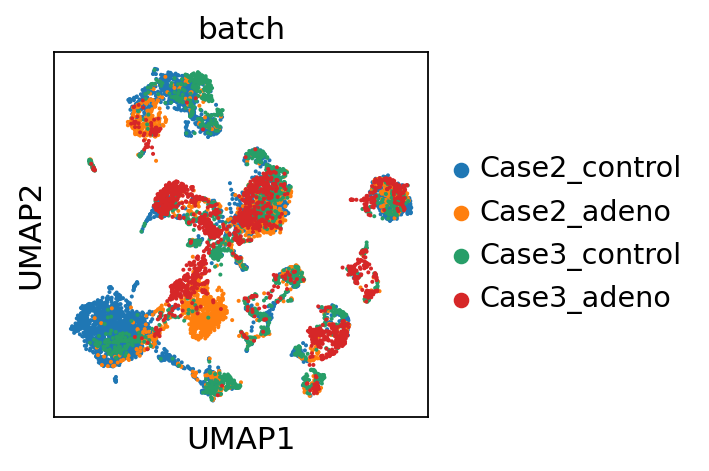

In [93]:
rcParams['figure.facecolor']='white'
rcParams['figure.figsize']=3,3
sc.pl.umap(adata, color=['batch'], frameon=True, show=False)

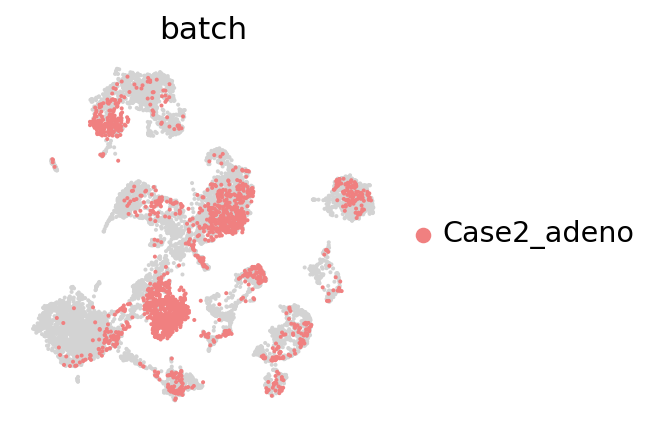

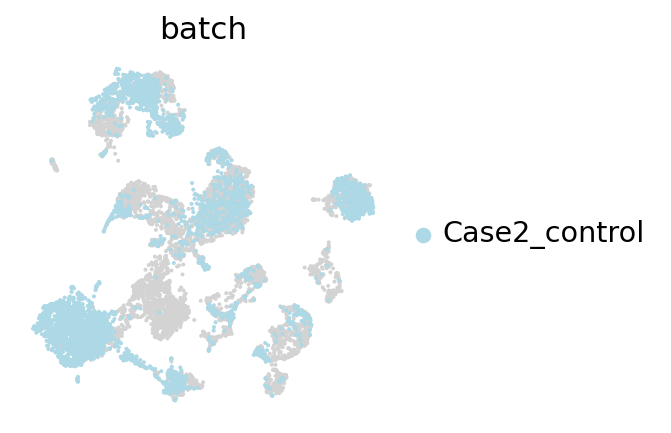

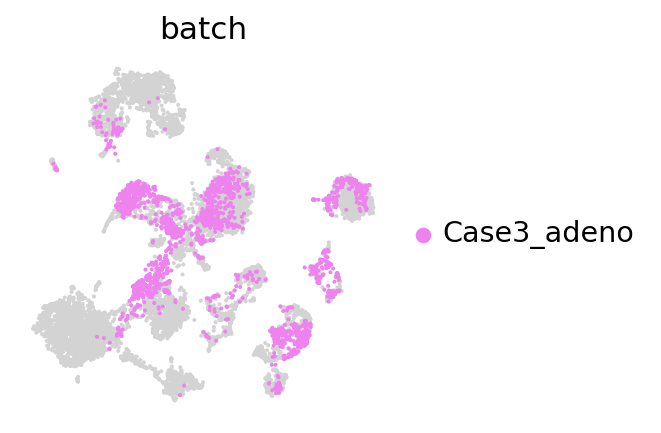

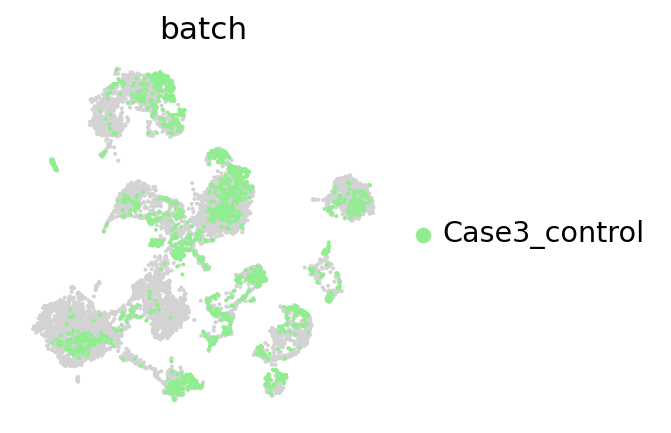

In [95]:
palette = ['lightblue','lightcoral','lightgreen','violet']
for i in sorted(list(set(adata.obs.batch))):
    rcParams['figure.facecolor']='white'
    rcParams['figure.figsize']=3,3
    sc.pl.umap(adata, color=['batch'], groups=i, frameon=False, palette=palette, show=False)

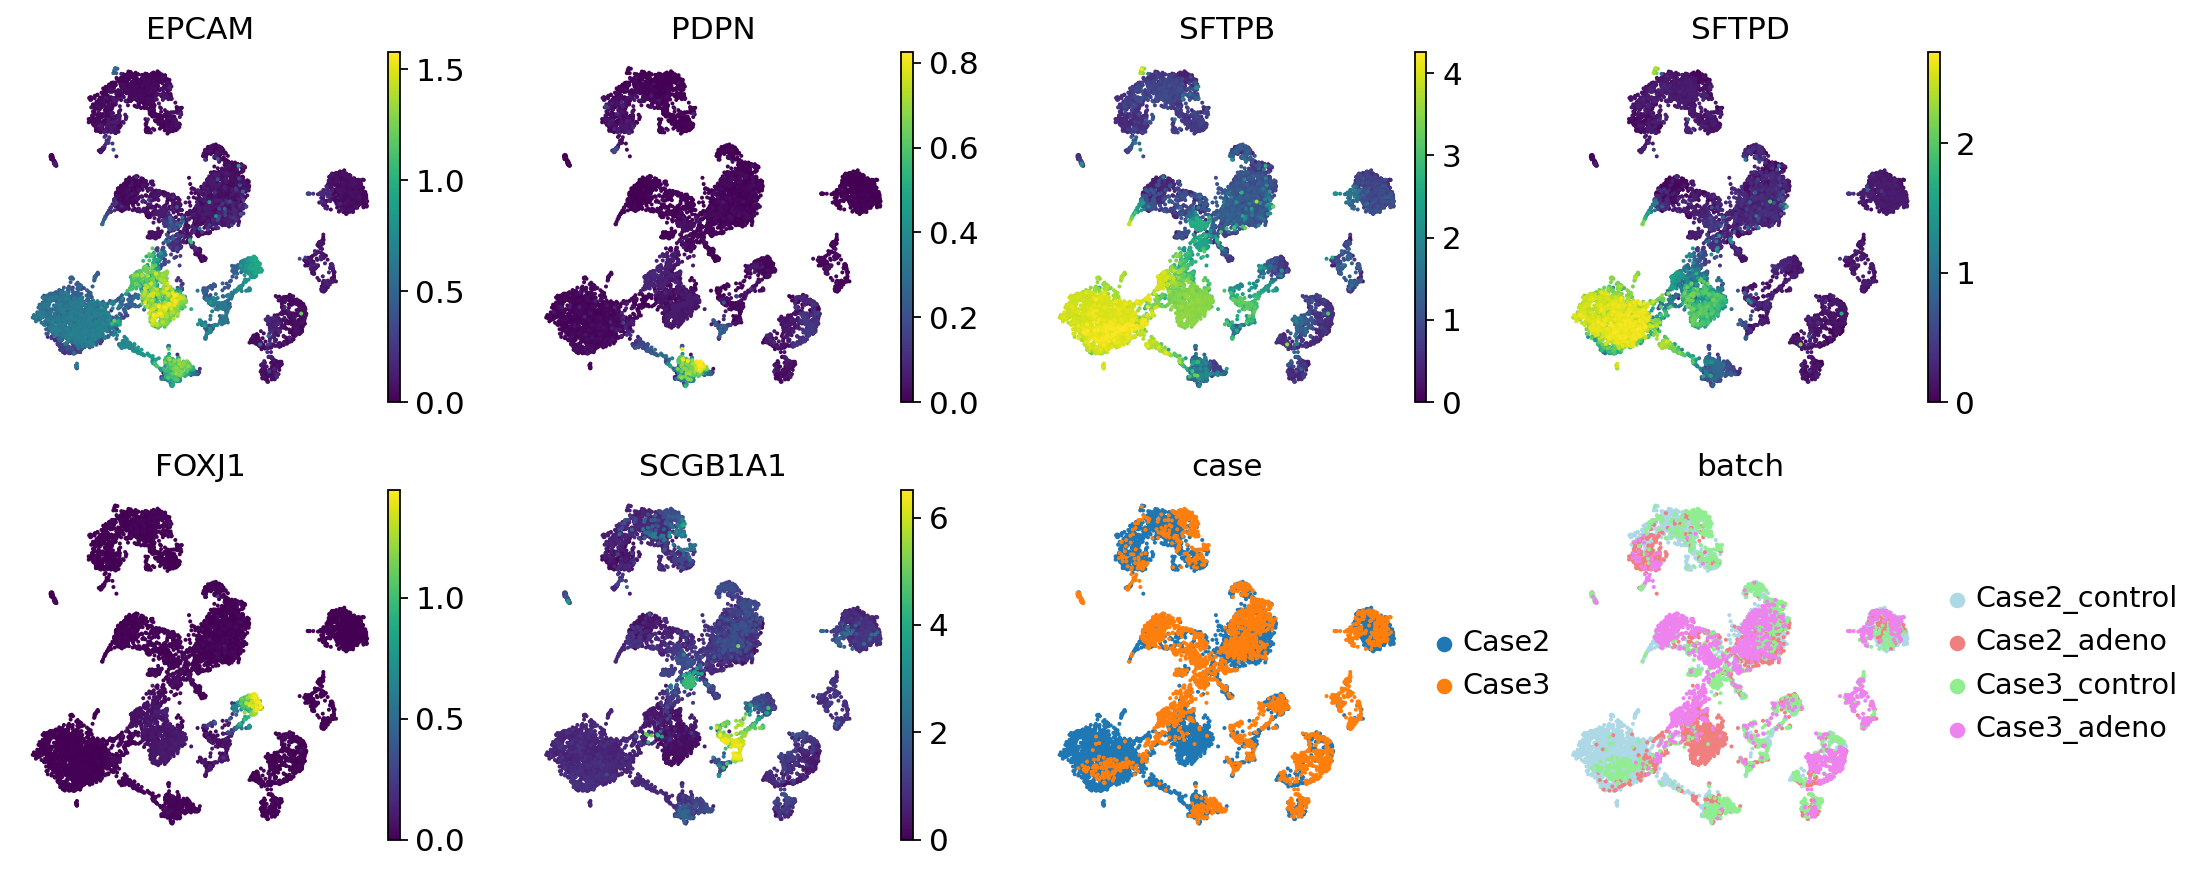

In [96]:
sc.pl.umap(adata, color=['EPCAM','PDPN','SFTPB','SFTPD','FOXJ1','SCGB1A1','case','batch'], frameon=False, use_raw=False, vmin=0, show=False)

In [97]:
scaled = sc.pp.scale(adata, copy=True)

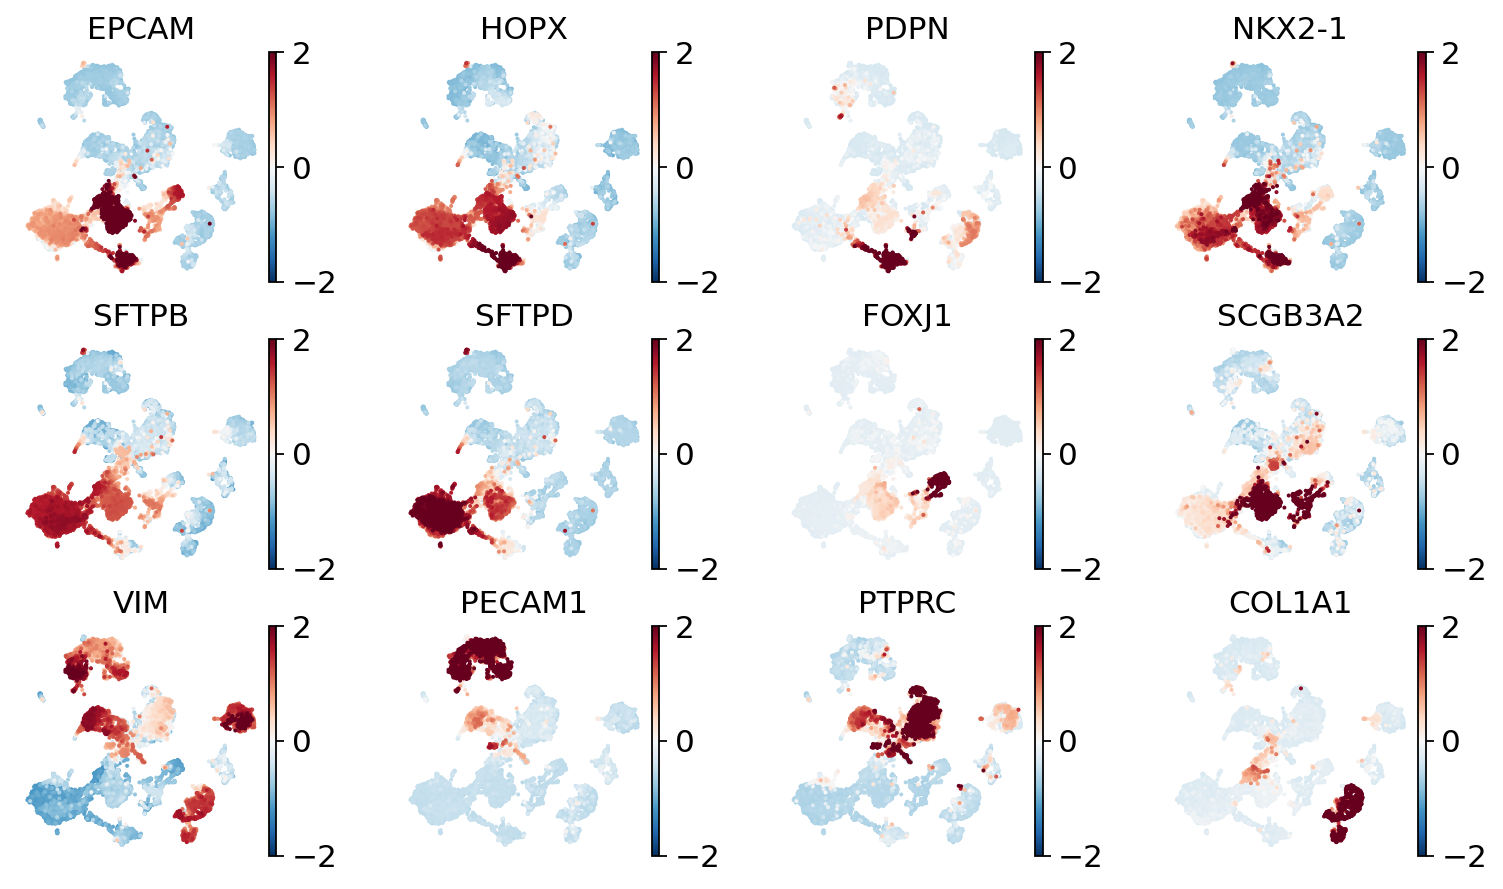

In [109]:
rcParams['figure.figsize']=2,2
sc.pl.umap(scaled, color=['EPCAM','HOPX','PDPN','NKX2-1','SFTPB','SFTPD','FOXJ1','SCGB3A2','VIM','PECAM1','PTPRC','COL1A1'], frameon=False, use_raw=False, vmin=-2, 
vmax=2, color_map='RdBu_r', show=False)

#### Unbiased community detection

In [100]:
sc.tl.leiden(adata, resolution=0.05, key_added='leiden0_05')
sc.tl.leiden(adata, resolution=0.1, key_added='leiden0_1')
sc.tl.leiden(adata, resolution=0.2, key_added='leiden0_2')
sc.tl.leiden(adata, resolution=0.4, key_added='leiden0_4')

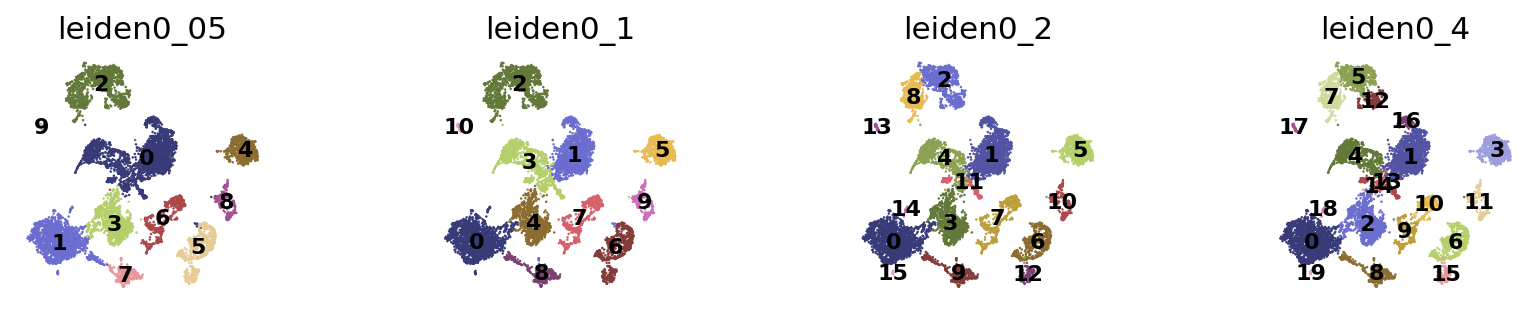

In [101]:
leiden_clusts=['leiden0_05','leiden0_1','leiden0_2','leiden0_4']

rcParams["figure.facecolor"]='white'
rcParams['figure.figsize'] = 2,2
sc.pl.umap(adata, color=leiden_clusts, wspace=0.5, legend_fontsize=10,legend_loc='on data', size=5, frameon=False, 
palette='tab20b', show=False)

#### Leiden0_1 was selected based on marker gene expression

Text(0.5, 1.0, '')

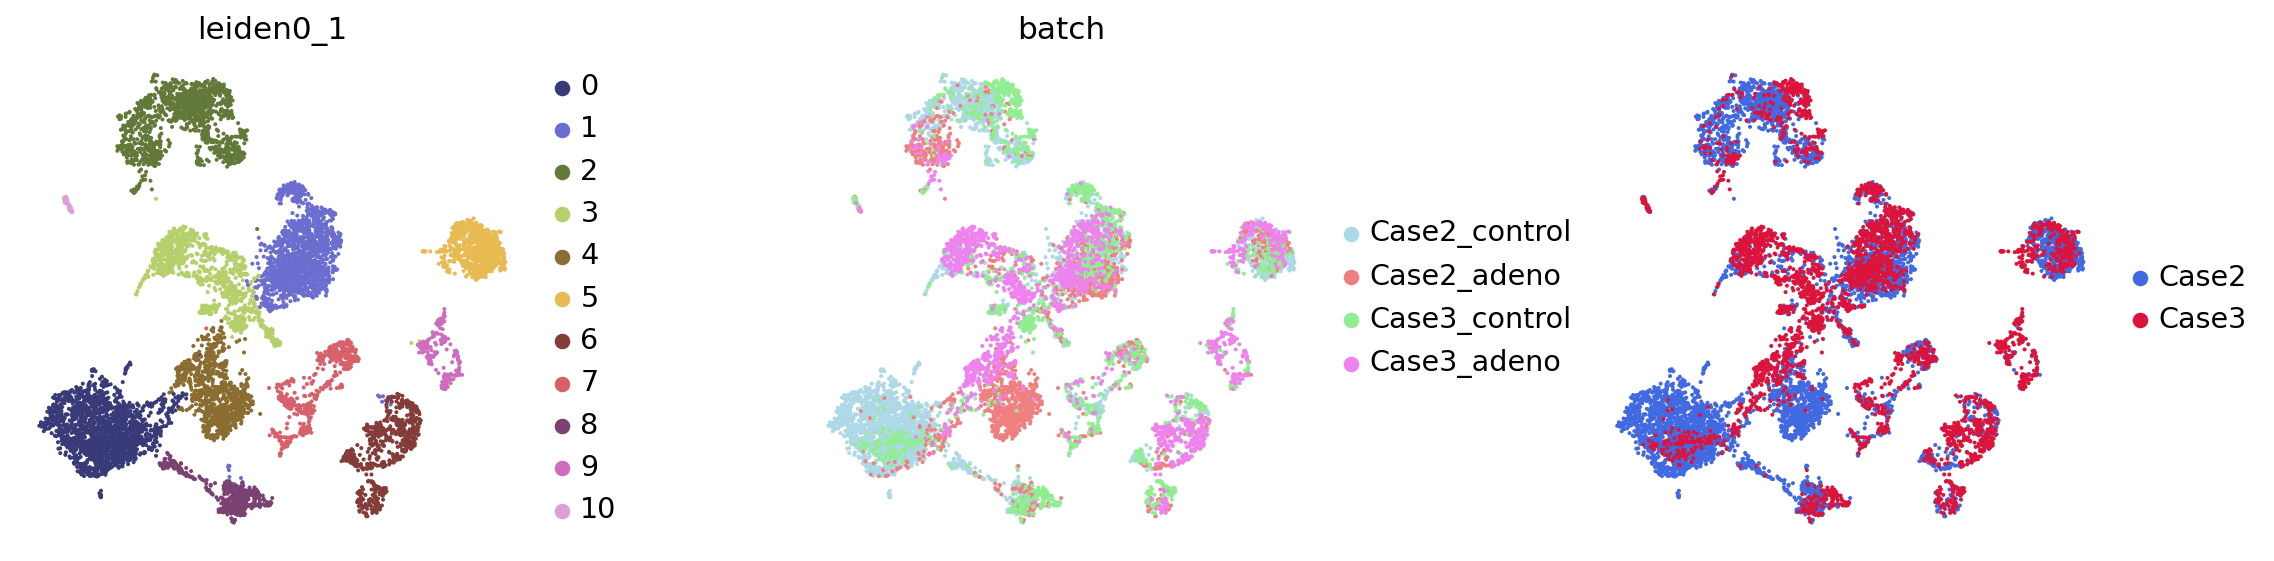

In [42]:
rcParams['figure.facecolor']='white'
rcParams['figure.figsize']=4,4
sc.pl.umap(adata, color=['leiden0_1','batch','case'], wspace=0.4, frameon=False, legend_loc='right margin', ncols=3, show=False)
plt.title('')

#### Check marker genes using a violin plot

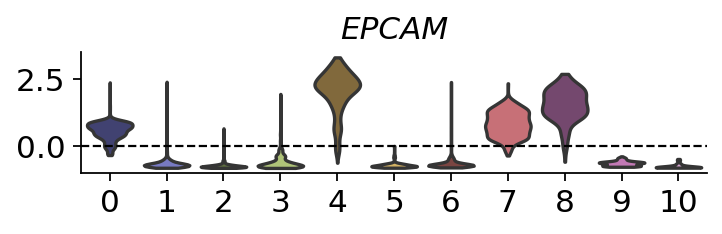

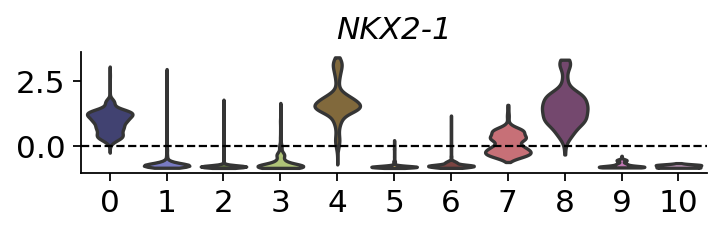

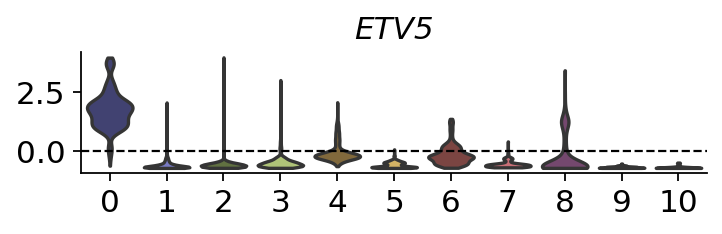

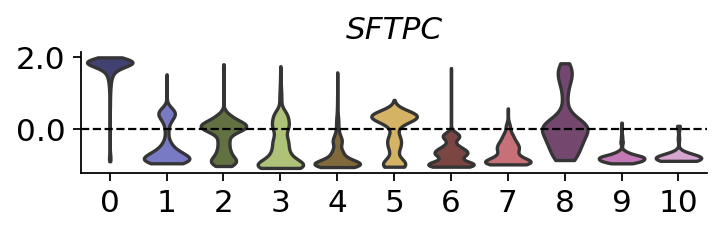

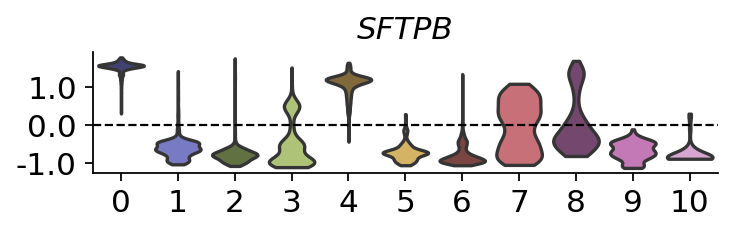

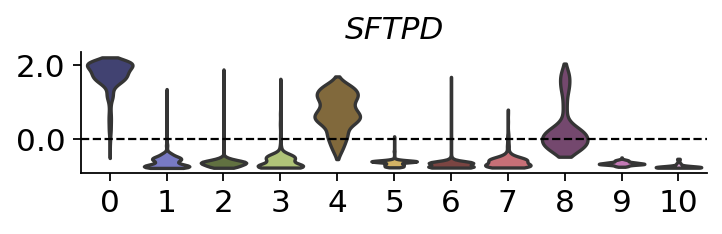

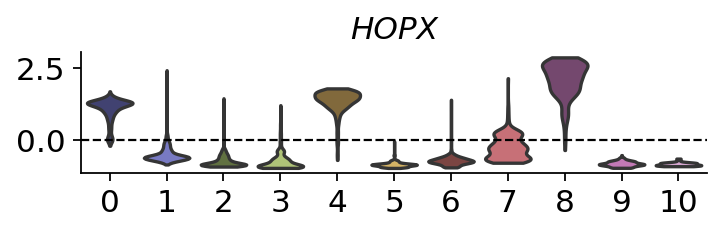

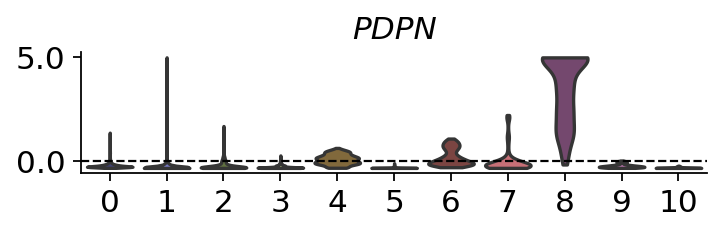

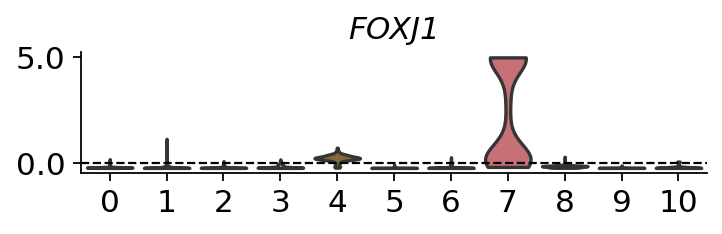

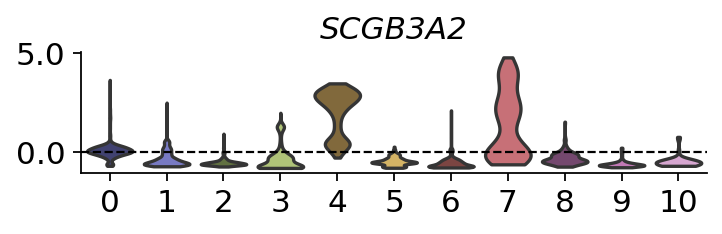

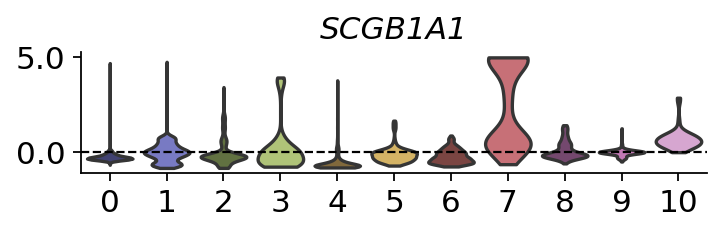

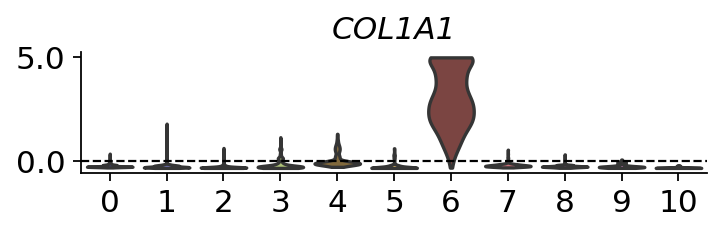

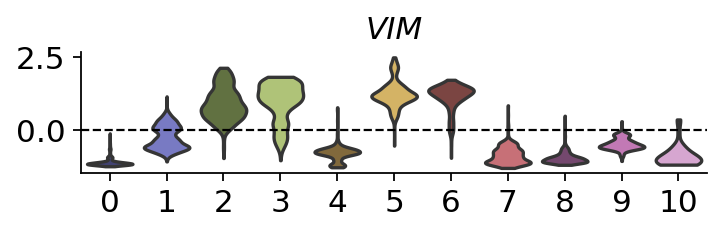

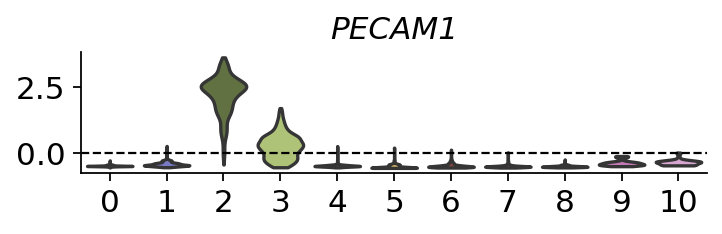

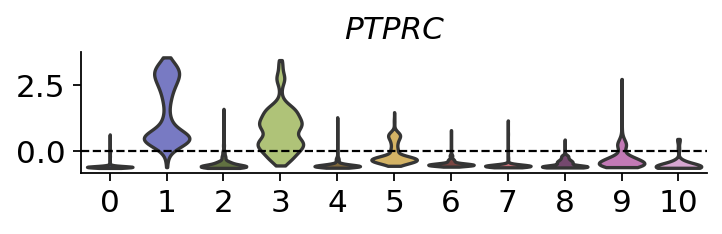

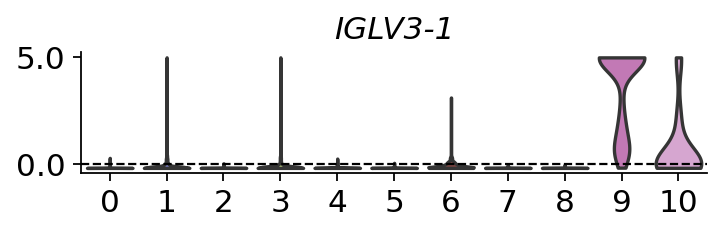

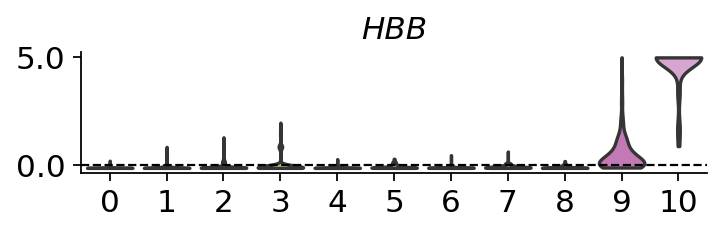

In [82]:
### Violin plot

genes = ['EPCAM','NKX2-1','ETV5','SFTPC','SFTPB','SFTPD','HOPX','PDPN','FOXJ1','SCGB3A2','SCGB1A1','COL1A1','VIM','PECAM1','PTPRC',
'IGLV3-1','HBB']

# plot
scaled = sc.pp.scale(adata, max_value=5, copy=True)
linecolor='black'
linewidth=1
linestyle='--'

for i in genes:
    rcParams['figure.figsize']= (5, 1)
    rcParams['figure.facecolor']='white'
    with axes_style({'axes.grid': False}):
        ax=sc.pl.violin(scaled, i, groupby='leiden0_1', use_raw=False, stripplot=False, jitter=False,
        #order = order, 
        show=False)
        despine(right=True)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        plt.axhline(0, color=linecolor, linestyle=linestyle, linewidth=linewidth)
        #ax.tick_params(axis='both', which='major', labelsize=10) # tick sizes
        #ax.yaxis.label.set_size(10) # x label size
        #ax.set_xticklabels(order, rotation = 0, fontsize=10)
        #ax.set_ylim(0) 
        ax.set_xlabel('')
        plt.ylabel('', fontsize=10)
        plt.title(i, fontstyle='italic')

#### Batch contributions to each cluster

In [127]:
print('Number of cells per cluster (leiden0_1):')
adata.obs.leiden0_1.value_counts()

Number of cells per cluster (leiden0_1):


0     1814
1     1578
2     1327
3     1028
4      881
5      771
6      636
7      462
8      409
9      212
10      43
Name: leiden0_1, dtype: int64

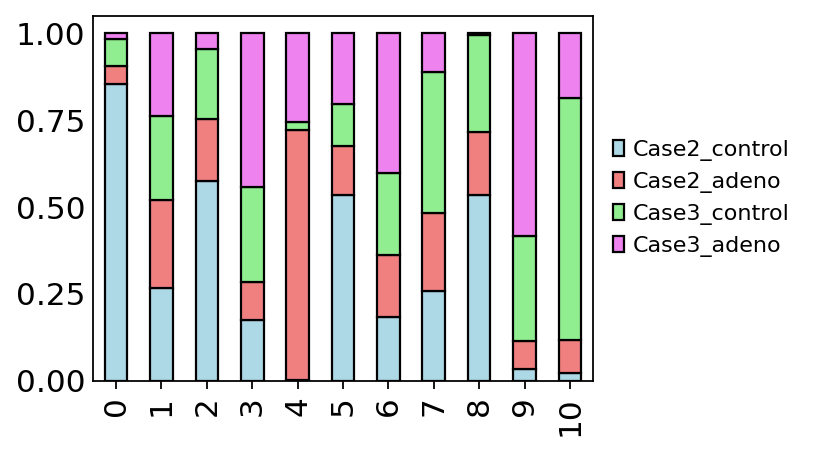

In [122]:
df=adata.obs.copy()
df_plot = df.groupby(['leiden0_1', 'batch']).size().reset_index().pivot(columns='batch', index='leiden0_1', values=0)

# normalize rows
# Credit: https://stackoverflow.com/questions/26537878/pandas-sum-across-columns-and-divide-each-cell-from-that-value
df3 = df_plot.div(df_plot.sum(axis=1), axis=0)

order = ['Case2_control','Case2_adeno','Case3_control','Case3_adeno']
df3 = df3[order]

#df3 = df3.sort_values(by = ['0 days','14 days', '10 days'], ascending=[True, False, False])

# Manually order the rows according to time point contributions
#df3 = df3.reindex(['2','15','9','8','10','7','11','4','1','12','5','14','3','6','0','13'])

# plot

color = ['lightblue','lightcoral','lightgreen','violet']

rcParams['figure.figsize'] = 4,3
with axes_style({'axes.grid': False}):
    ax = df3.plot(kind='bar', stacked=True, edgecolor='black', color = color
                 )
    ax.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1, frameon=False, title='', 
    title_fontsize=10, fontsize=10)
    ax.set_xlabel("", rotation=0, labelpad=10, fontsize=10)
    ax.set_ylabel("", rotation=90, labelpad=10, fontsize=10)
    #ax.set_xticklabels(df3.index, fontsize=10)
    #ax.set_yticklabels([0.0,0.5,1.0], fontsize=10)
    ax.tick_params(axis=u'y', which=u'both',length=0)
    #despine(right=True, left=True)

#### Differential Expression Analysis

In [129]:
ngenes = 3000
method = 'wilcoxon'
lst=['leiden0_1']
anndata = adata

for resolution in lst:
    print(f'Performing DE analysis for resolution={resolution}...')
    sc.tl.rank_genes_groups(anndata, groupby=resolution, key_added=f'rank_genes_{resolution}',
    method = method, n_genes=ngenes)

    # save data to adata_subset.uns
    result = anndata.uns[f'rank_genes_{resolution}']
    groups = result['names'].dtype.names

de_data = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

# Save DE results
result = adata.uns['rank_genes_leiden0_1']
groups = result['names'].dtype.names
de_data = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

Performing DE analysis for resolution=leiden0_1...


In [131]:
# Filter for significant DE genes, then visualize
sig_genes = dict()
clusters = list(set(adata.obs.leiden0_1))
clusters.sort(key=int)

for i in clusters:
    df1 = de_data.loc[(de_data[f'{i}_p'] < 0.05)] 
    df1 = df1[[f'{i}_n',f'{i}_p',f'{i}_l']]
    df1 = df1.sort_values(by=f'{i}_l', ascending=False) # sort by log fold value
    top = df1[f'{i}_n'].tolist() # convert to list
    #top_tf = [x for x in top if x in merged_tf_list] 
    print(f'Total sig genes in cluster{i} with pval<0.05:', len(top))
    top = top[:10] # can select the number of genes used for visualization if desired
    sig_genes.update({f'Cluster {i} genes': top})
    #print(f'Cluster {i} TFs:', top)

Total sig genes in cluster0 with pval<0.05: 3000
Total sig genes in cluster1 with pval<0.05: 520
Total sig genes in cluster2 with pval<0.05: 1763
Total sig genes in cluster3 with pval<0.05: 3000
Total sig genes in cluster4 with pval<0.05: 3000
Total sig genes in cluster5 with pval<0.05: 308
Total sig genes in cluster6 with pval<0.05: 2764
Total sig genes in cluster7 with pval<0.05: 3000
Total sig genes in cluster8 with pval<0.05: 1499
Total sig genes in cluster9 with pval<0.05: 40
Total sig genes in cluster10 with pval<0.05: 10


GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[21.05, 0, 0.2, 0.5, 0.25])

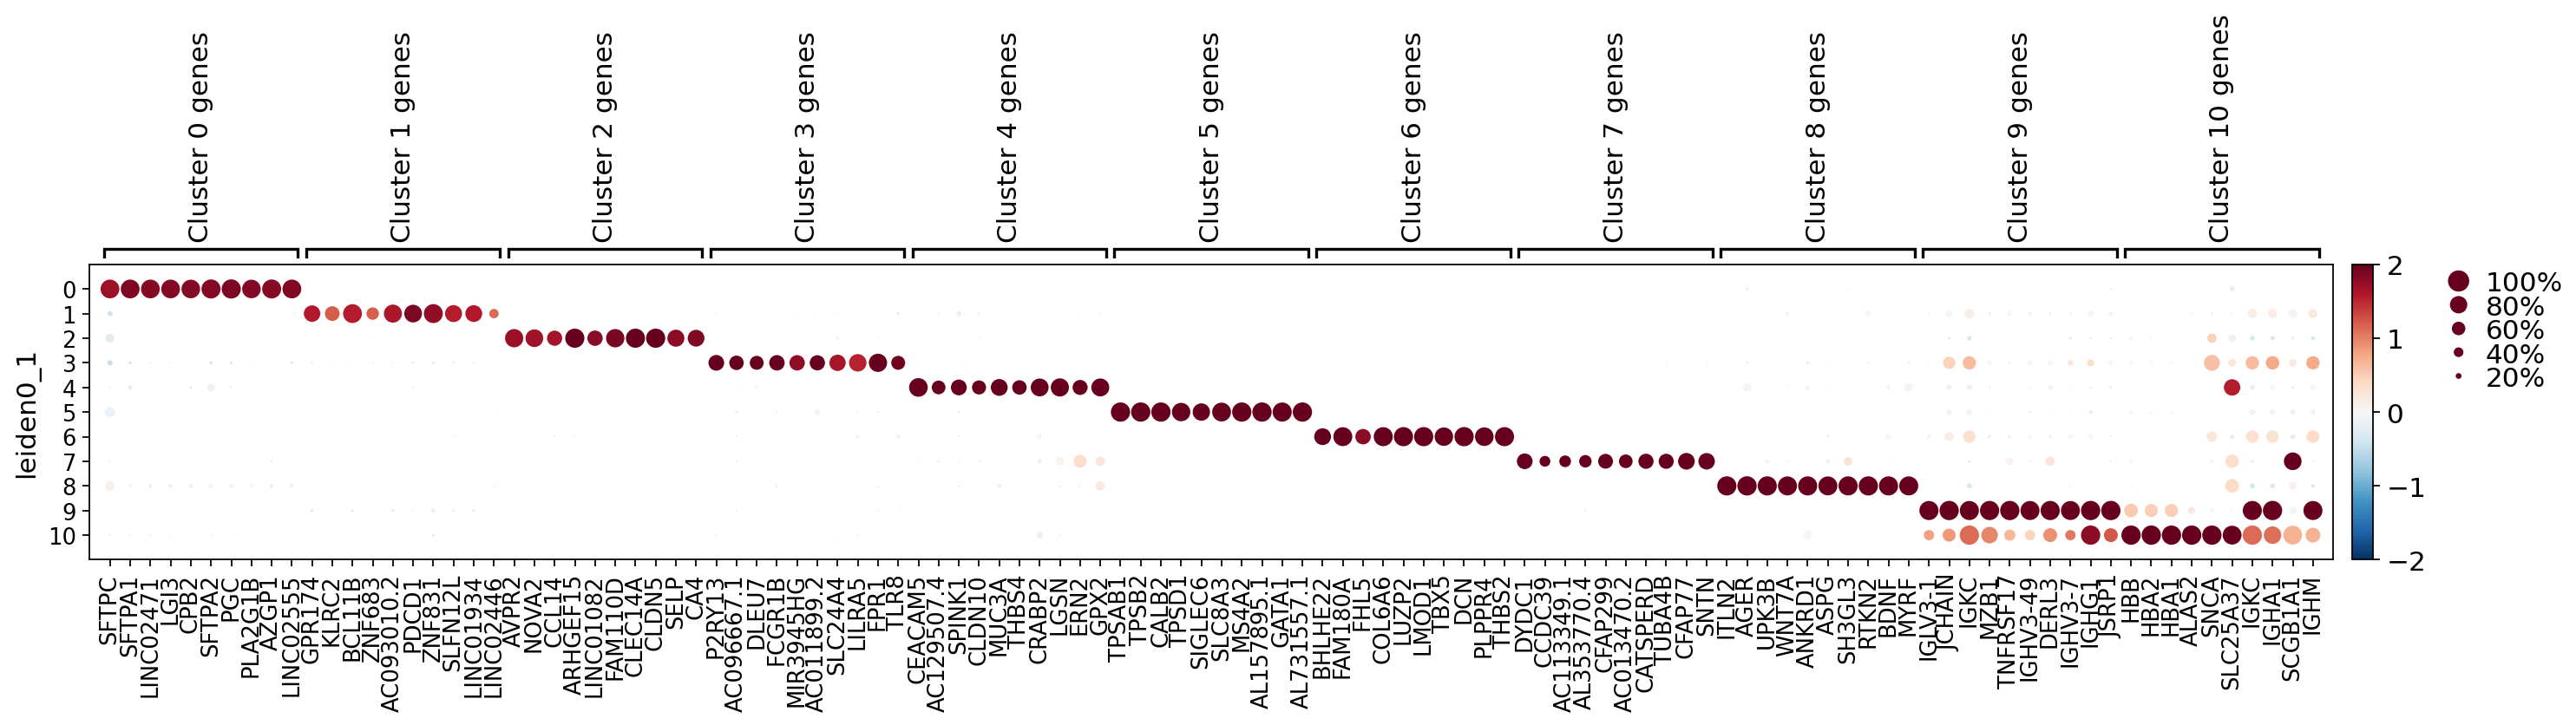

In [134]:
cmap='RdBu_r'
scaled = sc.pp.scale(adata, copy=True)

sc.pl.dotplot(scaled, sig_genes, color_map=cmap, use_raw=False, groupby='leiden0_1', 
vmin=-2, vmax=2, figsize=(22,3))

Cluster 9 has high DE for Immunoglobulin and antibody genes

In [148]:
#### Add annotation to adata.obs

adata.obs['annot'] = adata.obs['leiden0_1']

new_cluster_names = [
    'AT2 Normal',#0
    'Immune #1',#1
    'Endothelial',#2
    'Immune #2',#3
    'AT2 Stage IA',#4
    'Mast cells',#5, TPSAB1+ cells 
    'Fibroblasts',#6
    'Club/Ciliated',#7
    'AT1',#8
    'Blood #1',#9
    'Blood #2',#10
]

# Change names in copied column in adata.obs
adata.rename_categories('annot', new_cluster_names)

# Match annot colors to leiden0_1 colors
adata.uns.update({f'annot_colors': list(adata.uns['leiden0_1_colors'])})

#### Repeat Figure S6B from CSC paper to validate the reanalysis

Text(0.5, 0, '')

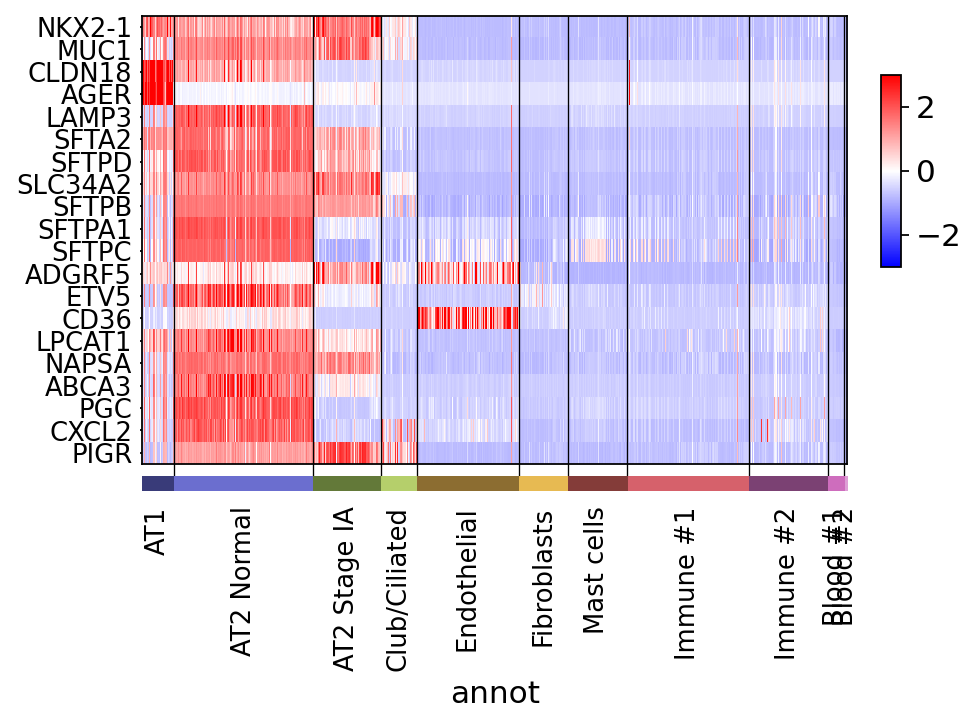

In [16]:
bdata = adata.copy()

# Order of the lineage
lin = ('AT1','AT2 Normal','AT2 Stage IA','Club/Ciliated','Endothelial','Fibroblasts','Mast cells','Immune #1','Immune #2','Blood #1','Blood #2')

# Reordering leiden labels using Categorical data type
bdata.obs['annot'] = bdata.obs['annot'].cat.reorder_categories(list(lin))

genes = ['NKX2-1','MUC1','CLDN18','AGER','LAMP3','SFTA2','SFTPD','SLC34A2','SFTPB','SFTPA1','SFTPC','ADGRF5','ETV5','CD36',
        'LPCAT1','NAPSA','ABCA3','PGC','CXCL2','PIGR']
    
# plot heatmap
scaled = sc.pp.scale(bdata, copy=True)
    
ax=sc.pl.heatmap(scaled, var_names=genes, groupby='annot', use_raw=False,
             cmap='bwr', swap_axes=True, figsize=(6,4), vmin=-3, vmax=3, show=False)
fig = plt.gcf()
cbar_ax = fig.axes[-1] # access cbar axes
plot_ax = fig.axes[0] # access the heatmap
cbar_ax.set_position(pos=[0.95,0.5,0.02,0.3]) # locxaxis,locyaxis,cbarwidth,cbarheight
plot_ax.set_xlabel('')
#plot_ax.axhline(y=0, color='black',linewidth=3)
#plot_ax.axhline(y=len(genes), color='black',linewidth=3)
#plot_ax.axvline(x=0, color='k',linewidth=3)
#plot_ax.axvline(x=len(at2_sub.obs.index), color='black',linewidth=3)

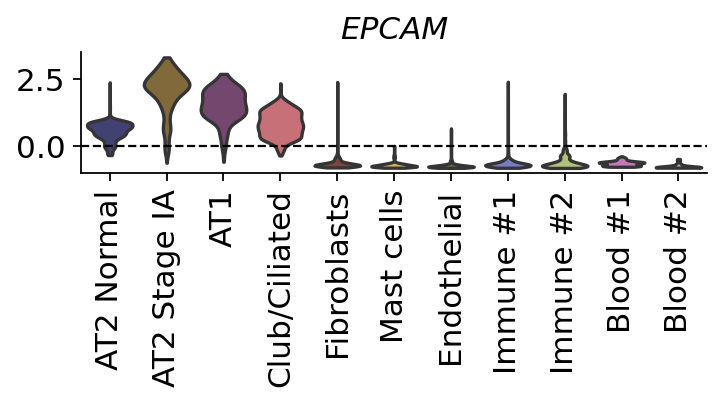

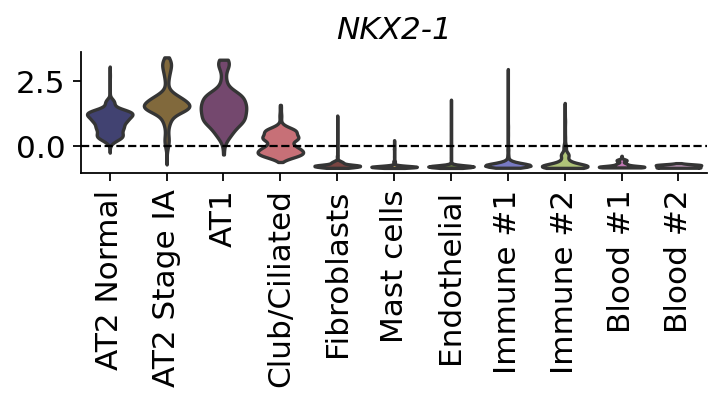

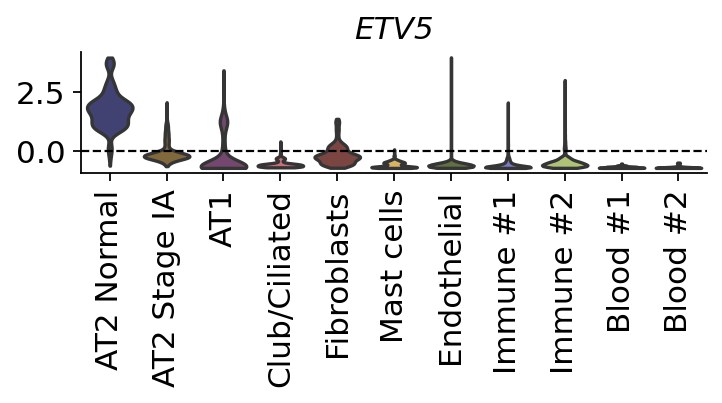

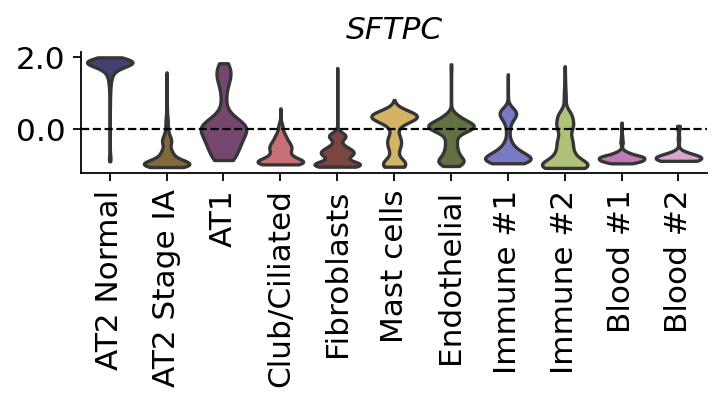

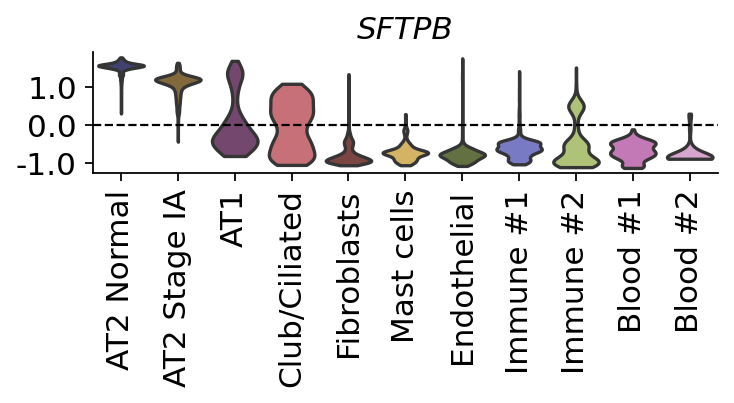

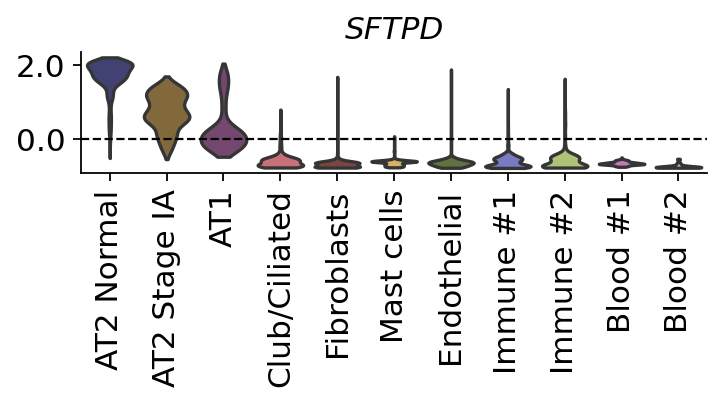

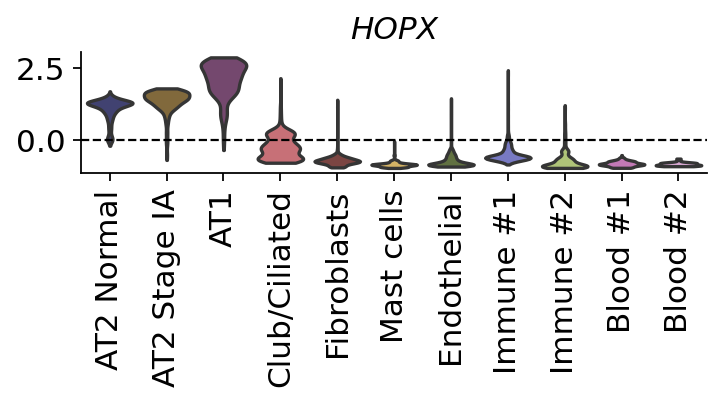

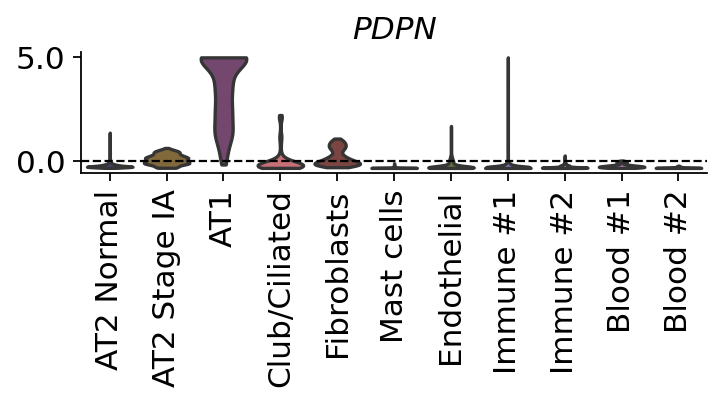

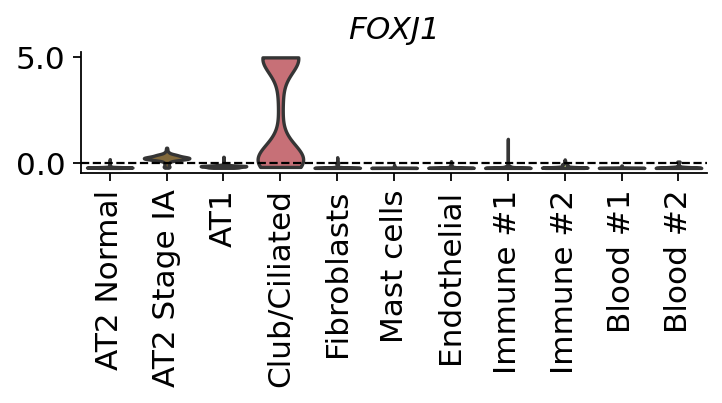

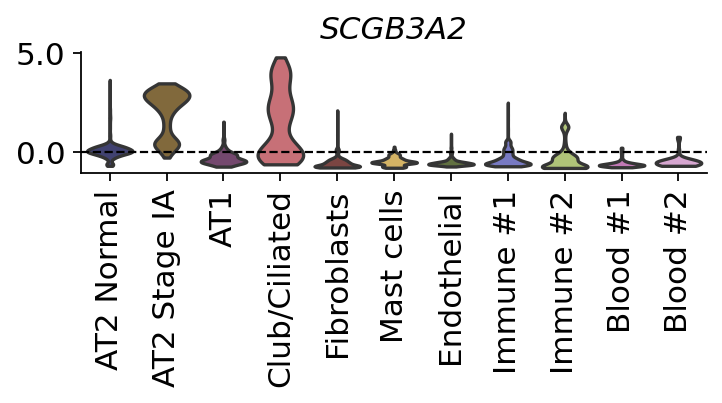

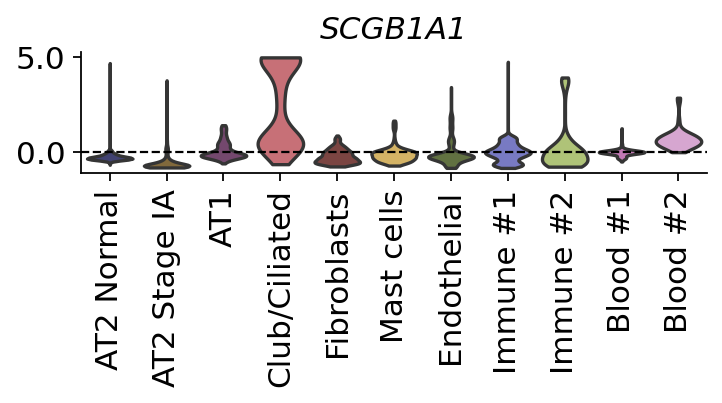

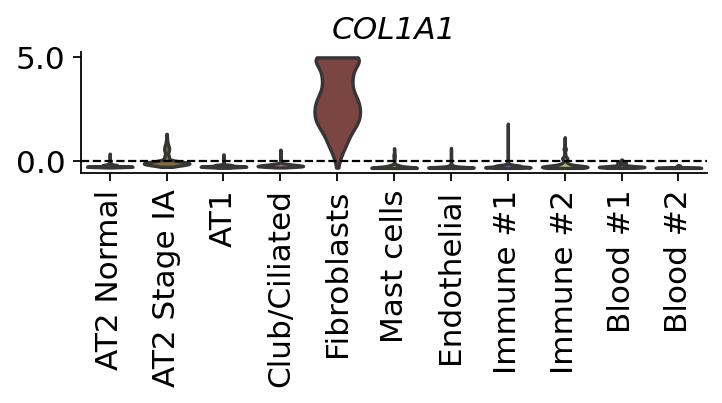

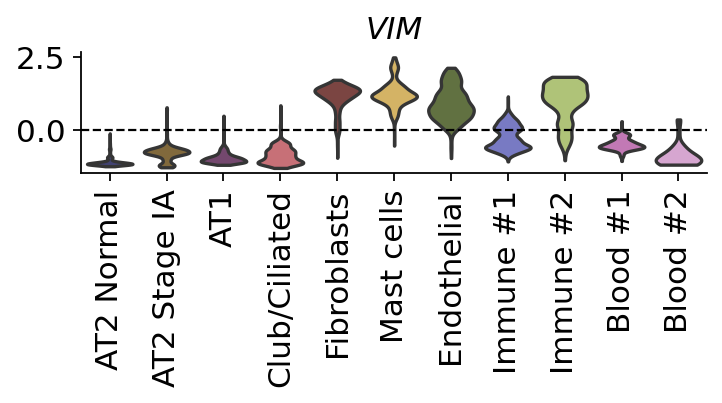

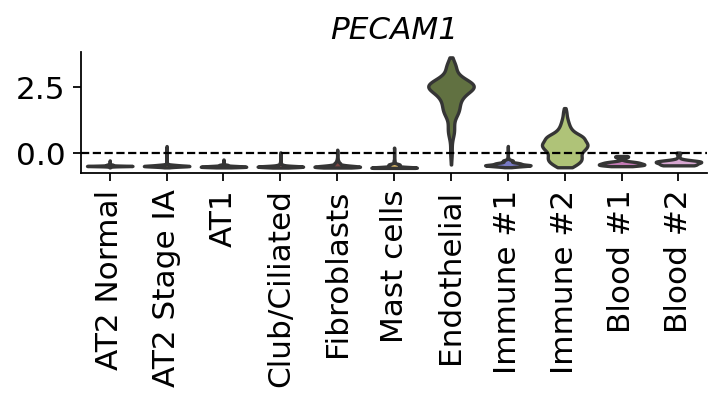

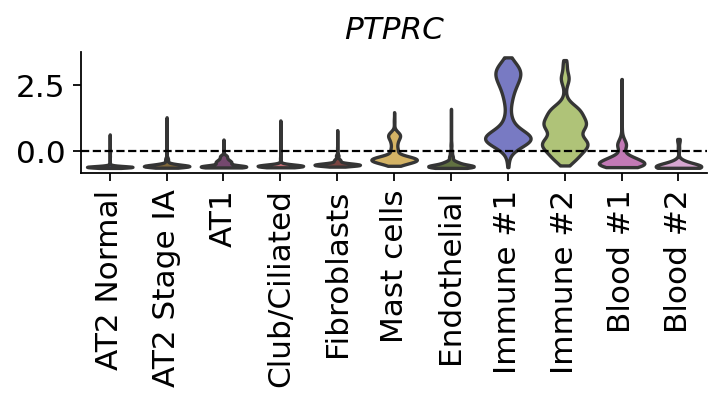

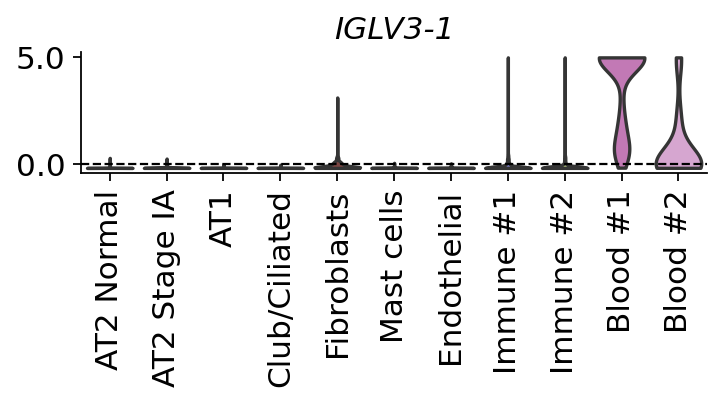

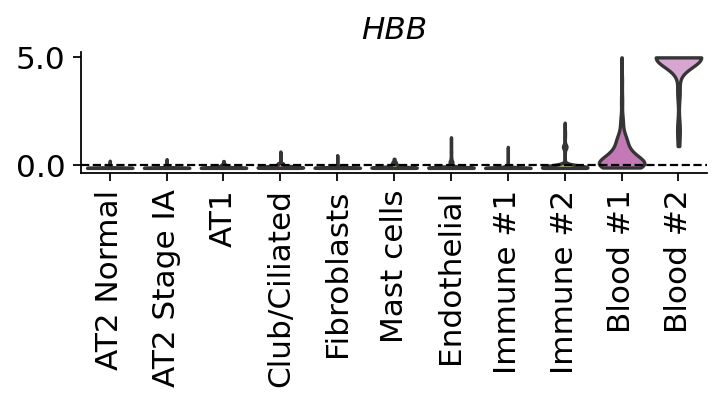

In [149]:
### Violin plot of marker genes with annotations on the x axis

genes = ['EPCAM','NKX2-1','ETV5','SFTPC','SFTPB','SFTPD','HOPX','PDPN','FOXJ1','SCGB3A2','SCGB1A1','COL1A1','VIM','PECAM1','PTPRC',
'IGLV3-1','HBB']

order = ['AT2 Normal','AT2 Stage IA','AT1','Club/Ciliated','Fibroblasts','Mast cells','Endothelial','Immune #1', 'Immune #2', 
         'Blood #1', 'Blood #2']

# plot
scaled = sc.pp.scale(adata, max_value=5, copy=True)
linecolor='black'
linewidth=1
linestyle='--'

for i in genes:
    rcParams['figure.figsize']= (5, 1)
    rcParams['figure.facecolor']='white'
    with axes_style({'axes.grid': False}):
        ax=sc.pl.violin(scaled, i, groupby='annot', use_raw=False, stripplot=False, jitter=False, order=order,
        #order = order, 
        show=False)
        despine(right=True)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        plt.axhline(0, color=linecolor, linestyle=linestyle, linewidth=linewidth)
        ax.set_xlabel('')
        plt.ylabel('', fontsize=10)
        plt.title(i, fontstyle='italic')
        plt.xticks(rotation=90)

#### Everything looks good. Human data is ready for analysis

Text(0.5, 1.0, '')

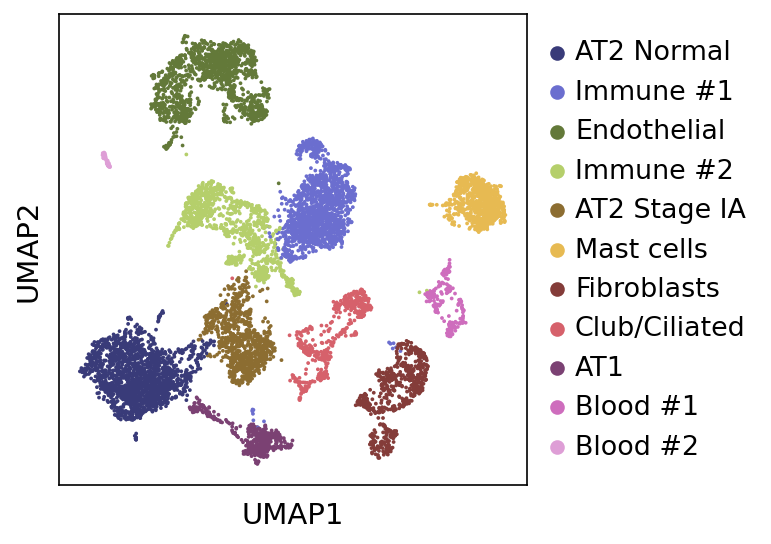

In [6]:
rcParams['figure.facecolor']='white'
rcParams['figure.figsize']=4,4
rcParams['figure.dpi']=150
sc.pl.umap(adata, color=['annot'], wspace=0.4, frameon=True, legend_loc='right margin', show=False)
plt.title('')

#### Make a plot with epi and mes only

In [3]:
list(set(adata.obs.annot))

['Blood #2',
 'Immune #2',
 'Immune #1',
 'Blood #1',
 'Fibroblasts',
 'Mast cells',
 'Endothelial',
 'Club/Ciliated',
 'AT2 Stage IA',
 'AT1',
 'AT2 Normal']

#### Subset data into cells of interest

In [3]:
human_at2_mes = adata[adata.obs['annot'].isin(['Fibroblasts','AT2 Normal','AT2 Stage IA'])]

Cells in the datasets: 3331


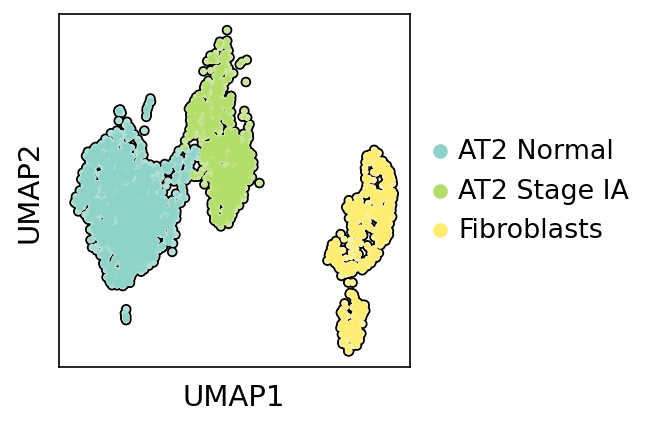

In [9]:
# Plot again for the figure
rcParams['figure.facecolor']='white'
rcParams['figure.figsize']=3,3
rcParams['figure.dpi']=150
sc.pl.umap(human_at2_mes, color=['annot'], wspace=0.6, frameon=True, legend_loc='right margin', show=False, add_outline=True, palette='Set3')
plt.title('')

print('Cells in the datasets:', len(human_at2_mes.obs.index))

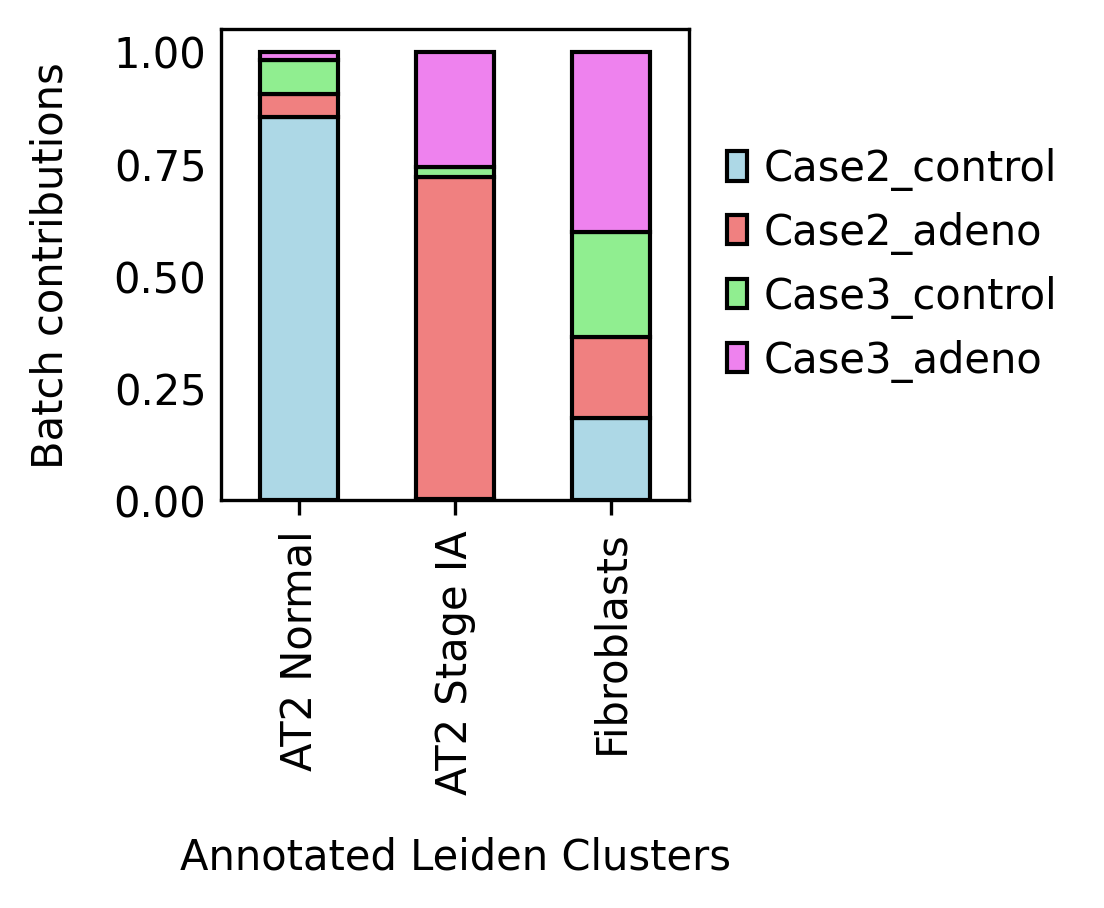

In [14]:
df=human_at2_mes.obs.copy()
df_plot = df.groupby(['annot', 'batch']).size().reset_index().pivot(columns='batch', index='annot', values=0)

# normalize rows
# Credit: https://stackoverflow.com/questions/26537878/pandas-sum-across-columns-and-divide-each-cell-from-that-value
df3 = df_plot.div(df_plot.sum(axis=1), axis=0)

order = ['Case2_control','Case2_adeno','Case3_control','Case3_adeno']
df3 = df3[order]

# plot

color = ['lightblue','lightcoral','lightgreen','violet']

rcParams['figure.figsize'] = 2,2
rcParams['figure.dpi'] = 300
with axes_style({'axes.grid': False}):
    ax = df3.plot(kind='bar', stacked=True, edgecolor='black', color=color)
    ax.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1, frameon=False, title='', 
              title_fontsize=10, fontsize=10)
    ax.set_xlabel("Annotated Leiden Clusters", rotation=0, labelpad=10, fontsize=10)
    ax.set_ylabel("Batch contributions", rotation=90, labelpad=10, fontsize=10)
    ax.tick_params(axis='both', labelsize=10)
    ax.tick_params(axis=u'y', which=u'both',length=0)
    #despine(right=True, left=True)

#### Marker gene heatmap

In [10]:
bdata.uns['annot_colors']

array(['#8dd3c7', '#b3de69', '#ffed6f'], dtype=object)

/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


Text(0.5, 0, '')

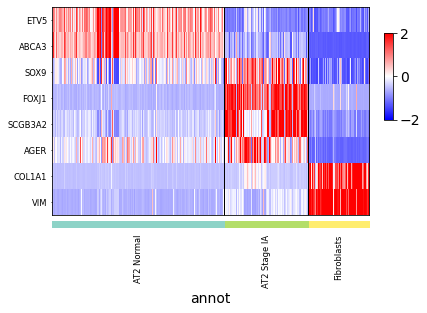

In [9]:
bdata = human_at2_mes.copy()

# Order of the lineage
lin = ('AT2 Normal','AT2 Stage IA','Fibroblasts')

# Reordering leiden labels using Categorical data type
bdata.obs['annot'] = bdata.obs['annot'].cat.reorder_categories(list(lin))

genes = ['ETV5','ABCA3','SOX9','FOXJ1','SCGB3A2','AGER','COL1A1','VIM']
    
# plot heatmap
scaled = sc.pp.scale(bdata, copy=True)
    
ax=sc.pl.heatmap(scaled, var_names=genes, groupby='annot', use_raw=False,
             cmap='bwr', swap_axes=True, figsize=(6,4), vmin=-2, vmax=2, show=False)
fig = plt.gcf()
cbar_ax = fig.axes[-1] # access cbar axes
plot_ax = fig.axes[0] # access the heatmap
cbar_ax.set_position(pos=[0.95,0.5,0.02,0.3]) # locxaxis,locyaxis,cbarwidth,cbarheight
plot_ax.set_xlabel('')
#plot_ax.axhline(y=0, color='black',linewidth=3)
#plot_ax.axhline(y=len(genes), color='black',linewidth=3)
#plot_ax.axvline(x=0, color='k',linewidth=3)
#plot_ax.axvline(x=len(at2_sub.obs.index), color='black',linewidth=3)

#### Subset the cancerous and non-cancerous AT2 clusters
- Cluster 0 = Non-cancerous AT2 cells
- Cluster 4 = Cancerous AT2 cells

In [5]:
at2_sub = adata[adata.obs['leiden0_1'].isin(['0','4'])]

[<AxesSubplot:title={'center':'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'leiden0_1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'annot'}, xlabel='UMAP1', ylabel='UMAP2'>]

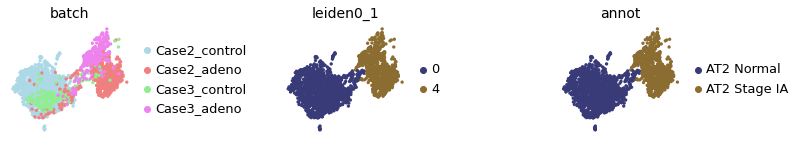

In [8]:
rcParams['figure.figsize']=2,2
rcParams['figure.facecolor']='white'
sc.pl.umap(at2_sub, color=['batch','leiden0_1','annot'], frameon=False, use_raw=False, vmin=-2, vmax=2, color_map='RdBu_r', 
wspace=1, show=False)

<AxesSubplot:title={'center':'annot'}, xlabel='UMAP1', ylabel='UMAP2'>

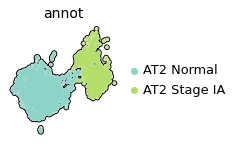

In [15]:
palette = ['#8dd3c7', '#b3de69']

rcParams['figure.figsize']=2,2
rcParams['figure.facecolor']='white'
sc.pl.umap(at2_sub, color=['annot'], frameon=False, use_raw=False, vmin=-2, vmax=2, color_map='RdBu_r', add_outline=True,
wspace=1, palette = palette, show=False)

/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


Text(0.5, 0, '')

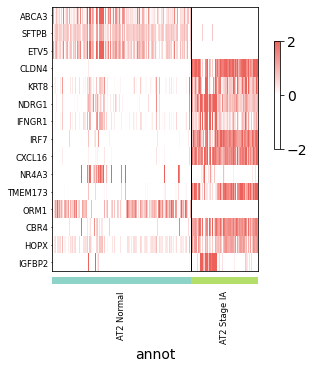

In [16]:
# Plot injury response genes

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white', 'white', '#EC625B'])

genes = ['ABCA3', 'SFTPB', 'ETV5', 'CLDN4', 'KRT8', 'NDRG1', 'IFNGR1', 'IRF7', 'CXCL16', 'NR4A3', 'TMEM173', 'ORM1', 'CBR4', 'HOPX', 'IGFBP2']
    
# plot heatmap
scaled = sc.pp.scale(at2_sub, copy=True)
    
ax=sc.pl.heatmap(scaled, var_names=genes, groupby='annot', use_raw=False,
             cmap=cmap, swap_axes=True, figsize=(4,5), vmin=-2, vmax=2, show=False)
fig = plt.gcf()
cbar_ax = fig.axes[-1] # access cbar axes
plot_ax = fig.axes[0] # access the heatmap
cbar_ax.set_position(pos=[0.95,0.5,0.02,0.3]) # locxaxis,locyaxis,cbarwidth,cbarheight
plot_ax.set_xlabel('')
#plot_ax.axhline(y=0, color='black',linewidth=3)
#plot_ax.axhline(y=len(genes), color='black',linewidth=3)
#plot_ax.axvline(x=0, color='k',linewidth=3)
#plot_ax.axvline(x=len(at2_sub.obs.index), color='black',linewidth=3)


#### Differential Expression Analysis using AT2 clusters only

In [152]:
ngenes = 3000
method = 'wilcoxon'
lst=['annot']
anndata = at2_sub

for resolution in lst:
    print(f'Performing DE analysis for resolution={resolution}...')
    sc.tl.rank_genes_groups(anndata, groupby=resolution, key_added=f'rank_genes_{resolution}',
    method = method, n_genes=ngenes)

    # save data to adata_subset.uns
    result = anndata.uns[f'rank_genes_{resolution}']
    groups = result['names'].dtype.names

de_data = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

# Save DE results
result = at2_sub.uns['rank_genes_annot']
groups = result['names'].dtype.names
de_data = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

Trying to set attribute `.uns` of view, copying.


Performing DE analysis for resolution=annot...


In [105]:
# Filter for significant DE genes, then visualize
sig_genes = dict()
all_genes = dict()
clusters = ['AT2 Normal', 'AT2 Stage IA']
#clusters.sort(key=int)

for i in clusters:
    df1 = de_data.loc[(de_data[f'{i}_p'] < 0.05)] 
    df1 = df1[[f'{i}_n',f'{i}_p',f'{i}_l']]
    df1 = df1.sort_values(by=f'{i}_l', ascending=False) # sort by log fold value
    top = df1[f'{i}_n'].tolist() # convert to list
    #top_tf = [x for x in top if x in merged_tf_list] 
    print(f'Total sig genes in cluster{i} with pval<0.05:', len(top))
    all_genes.update({f'Cluster {i} genes': top})
    top = top[:10] # can select the number of genes used for visualization if desired
    print(f'Top sig genes in cluster{i} with pval<0.05:', len(top))
    sig_genes.update({f'Cluster {i} genes': top})
    #print(f'Cluster {i} TFs:', top)

Total sig genes in clusterAT2 Normal with pval<0.05: 854
Top sig genes in clusterAT2 Normal with pval<0.05: 10
Total sig genes in clusterAT2 Stage IA with pval<0.05: 3000
Top sig genes in clusterAT2 Stage IA with pval<0.05: 10


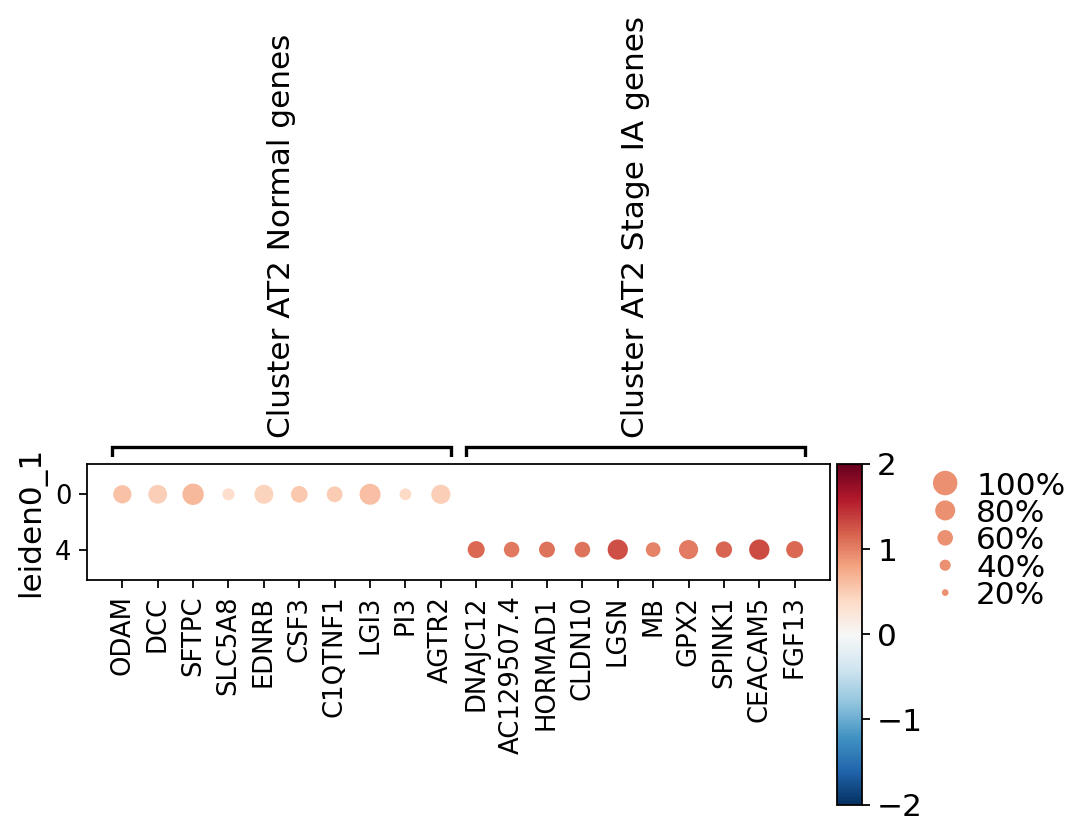

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[6.05, 0, 0.2, 0.5, 0.25])

In [106]:
cmap='RdBu_r'
scaled = sc.pp.scale(at2_sub, copy=True)

sc.pl.dotplot(scaled, sig_genes, color_map=cmap, use_raw=False, groupby='leiden0_1', 
vmin=-2, vmax=2, figsize=(7,3))

#### Subset the mesenchyme data
- Try to identify pericytes

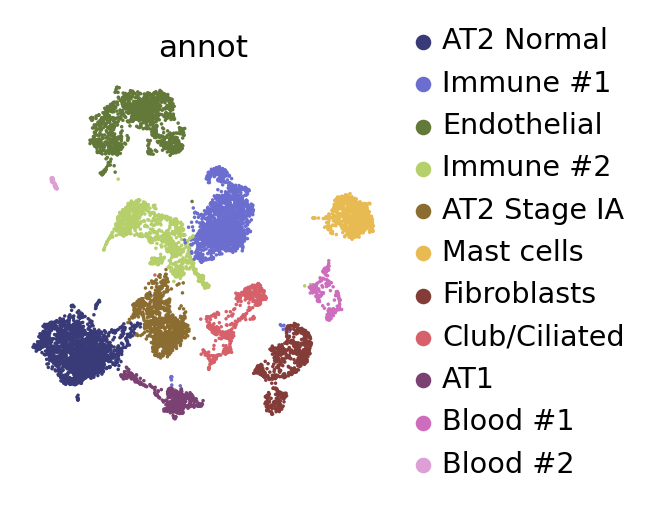

In [6]:
rcParams['figure.figsize']=3,3
sc.pl.umap(adata, color=['annot'], frameon=False, use_raw=False, color_map='RdBu_r', 
size=10, vmin=-2, vmax=2, wspace=1, show=False)

<AxesSubplot:title={'center':'annot'}, xlabel='UMAP1', ylabel='UMAP2'>

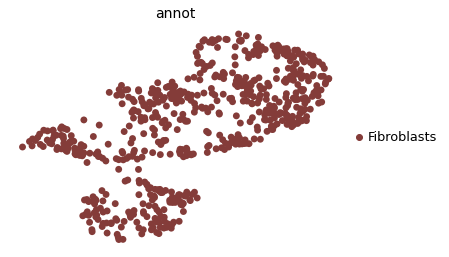

In [3]:
mes_sub = adata[adata.obs['annot'].isin(['Fibroblasts'])]

rcParams['figure.figsize']=2,2
sc.pl.umap(mes_sub, color=['annot'], frameon=False, use_raw=False, vmin=-2, vmax=2, color_map='RdBu_r', 
wspace=1, show=False)

In [4]:
print('Number of mesenchymal cells')
print(len(mes_sub.obs.index))

Number of mesenchymal cells
636


#### Recompute the nearest neighbor graph and UMAP

In [5]:
# Scanorama creates a PCA embedding so there is no need to calculate PCA again
sc.pp.neighbors(mes_sub, n_neighbors=5, n_pcs=20, use_rep='SC')
sc.tl.umap(mes_sub)

#### Find mesenchymal clusters in the human data

In [7]:
sc.tl.leiden(mes_sub, resolution=0.05, key_added='leiden0_05')
sc.tl.leiden(mes_sub, resolution=0.1, key_added='leiden0_1')
sc.tl.leiden(mes_sub, resolution=0.2, key_added='leiden0_2')
sc.tl.leiden(mes_sub, resolution=0.3, key_added='leiden0_3')
sc.tl.leiden(mes_sub, resolution=0.4, key_added='leiden0_4')

[<AxesSubplot:title={'center':'leiden0_05'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'leiden0_1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'leiden0_2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'leiden0_3'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'leiden0_4'}, xlabel='UMAP1', ylabel='UMAP2'>]

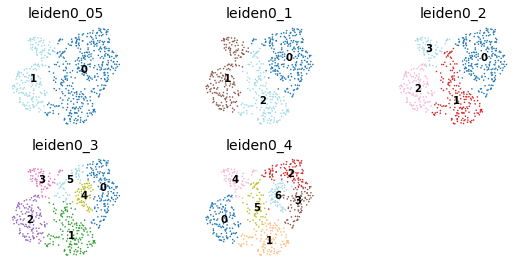

In [8]:
leiden_clusts=['leiden0_05','leiden0_1','leiden0_2','leiden0_3','leiden0_4']

rcParams["figure.facecolor"]='white'
rcParams['figure.figsize'] = 2,2
sc.pl.umap(mes_sub, color=leiden_clusts, wspace=0.5, legend_fontsize=10,legend_loc='on data', size=10, frameon=False, 
palette='tab20', ncols=3, show=False)

#### Differential expression analysis

In [9]:
ngenes = 3000
method = 'wilcoxon'
lst=['leiden0_2']
anndata = mes_sub

for resolution in lst:
    print(f'Performing DE analysis for resolution={resolution}...')
    sc.tl.rank_genes_groups(anndata, groupby=resolution, key_added=f'rank_genes_{resolution}',
    method = method, n_genes=ngenes)

    # save data to adata_subset.uns
    result = anndata.uns[f'rank_genes_{resolution}']
    groups = result['names'].dtype.names

de_data = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

# Save DE results
result = mes_sub.uns['rank_genes_leiden0_2']
groups = result['names'].dtype.names
de_data = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

Performing DE analysis for resolution=leiden0_2...


#### Investigate leiden0_2 first to find more detail

In [11]:
result = mes_sub.uns['rank_genes_leiden0_2']
groups = result['names'].dtype.names
de_data = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

# Filter for significant DE genes, then visualize
sig_genes = dict()
clusters = list(set(mes_sub.obs.leiden0_2))
clusters.sort(key=int)

for i in clusters:
    df1 = de_data.loc[(de_data[f'{i}_p'] < 0.05)] 
    df1 = df1[[f'{i}_n',f'{i}_p',f'{i}_l']]
    df1 = df1.sort_values(by=f'{i}_l', ascending=False) # sort by log fold value
    top = df1[f'{i}_n'].tolist() # convert to list
    #top_tf = [x for x in top if x in merged_tf_list] 
    print(f'Total sig genes in cluster{i} with pval<0.05:', len(top))
    top = top[:10] # can select the number of genes used for visualization if desired
    sig_genes.update({f'Cluster {i} genes': top})
    print(f'Cluster {i} top genes:', top)

Total sig genes in cluster0 with pval<0.05: 1920
Cluster 0 top genes: ['NTNG1', 'FBLN1', 'LUM', 'STEAP1', 'C3', 'C7', 'GPC3', 'CFD', 'SLC38A5', 'FGFR4']
Total sig genes in cluster1 with pval<0.05: 24
Cluster 1 top genes: ['IGLC3', 'IGKC', 'IGHM', 'IGLC2', 'JCHAIN', 'IGHA1', 'LYZ', 'HLA-DRA', 'SFTPB', 'SCGB3A1']
Total sig genes in cluster2 with pval<0.05: 354
Cluster 2 top genes: ['LDB3', 'HIGD1B', 'GJA4', 'PCDH1', 'LAMC3', 'MCAM', 'COX4I2', 'LGI4', 'ESAM', 'DGKG']
Total sig genes in cluster3 with pval<0.05: 389
Cluster 3 top genes: ['WIF1', 'CLU', 'SCARA3', 'PCSK1N', 'TSLP', 'BCHE', 'KCNK17', 'LINC00632', 'VSNL1', 'CCDC146']


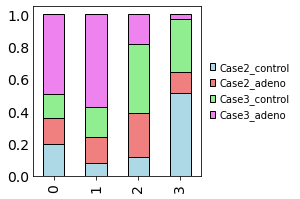

In [12]:
df=mes_sub.obs.copy()
df_plot = df.groupby(['leiden0_2', 'batch']).size().reset_index().pivot(columns='batch', index='leiden0_2', values=0)

# normalize rows
# Credit: https://stackoverflow.com/questions/26537878/pandas-sum-across-columns-and-divide-each-cell-from-that-value
df3 = df_plot.div(df_plot.sum(axis=1), axis=0)

order = ['Case2_control','Case2_adeno','Case3_control','Case3_adeno']
df3 = df3[order]

# plot
color = ['lightblue','lightcoral','lightgreen','violet']

rcParams['figure.figsize'] = 3,3
with axes_style({'axes.grid': False}):
    ax = df3.plot(kind='bar', stacked=True, edgecolor='black', color = color
                 )
    ax.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1, frameon=False, title='', 
    title_fontsize=10, fontsize=10)
    ax.set_xlabel("", rotation=0, labelpad=10, fontsize=10)
    ax.set_ylabel("", rotation=90, labelpad=10, fontsize=10)
    #ax.set_xticklabels(df3.index, fontsize=10)
    #ax.set_yticklabels([0.0,0.5,1.0], fontsize=10)
    ax.tick_params(axis=u'y', which=u'both',length=0)
    #despine(right=True, left=True)

Total sig genes in cluster0 with pval<0.05: 1920
Cluster 0 top genes: ['NTNG1', 'FBLN1', 'LUM', 'STEAP1', 'C3', 'C7', 'GPC3', 'CFD', 'SLC38A5', 'FGFR4']
Total sig genes in cluster1 with pval<0.05: 24
Cluster 1 top genes: ['IGLC3', 'IGKC', 'IGHM', 'IGLC2', 'JCHAIN', 'IGHA1', 'LYZ', 'HLA-DRA', 'SFTPB', 'SCGB3A1']
Total sig genes in cluster2 with pval<0.05: 354
Cluster 2 top genes: ['LDB3', 'HIGD1B', 'GJA4', 'PCDH1', 'LAMC3', 'MCAM', 'COX4I2', 'LGI4', 'ESAM', 'DGKG']
Total sig genes in cluster3 with pval<0.05: 389
Cluster 3 top genes: ['WIF1', 'CLU', 'SCARA3', 'PCSK1N', 'TSLP', 'BCHE', 'KCNK17', 'LINC00632', 'VSNL1', 'CCDC146']


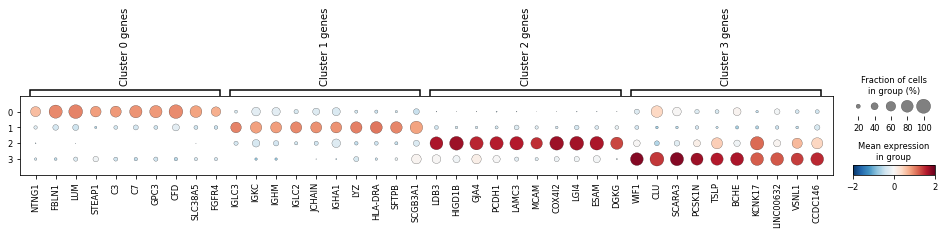

In [14]:
# Filter for significant DE genes, then visualize
sig_genes = dict()
clusters = list(set(mes_sub.obs.leiden0_2))
clusters.sort(key=int)

for i in clusters:
    df1 = de_data.loc[(de_data[f'{i}_p'] < 0.05)] 
    df1 = df1[[f'{i}_n',f'{i}_p',f'{i}_l']]
    df1 = df1.sort_values(by=f'{i}_l', ascending=False) # sort by log fold value
    top = df1[f'{i}_n'].tolist() # convert to list
    #top_tf = [x for x in top if x in merged_tf_list] 
    print(f'Total sig genes in cluster{i} with pval<0.05:', len(top))
    top = top[:10] # can select the number of genes used for visualization if desired
    sig_genes.update({f'Cluster {i} genes': top})
    print(f'Cluster {i} top genes:', top)
    
cmap='RdBu_r'
scaled = sc.pp.scale(mes_sub, copy=True)

sc.pl.dotplot(scaled, sig_genes, color_map=cmap, use_raw=False, groupby='leiden0_2', 
vmin=-2, vmax=2)

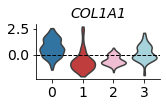

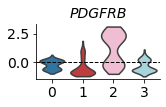

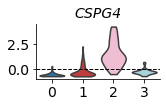

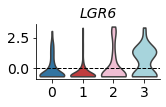

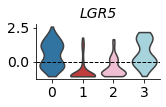

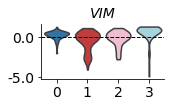

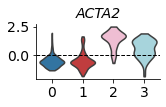

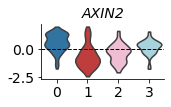

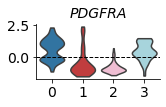

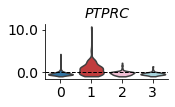

In [16]:
### Violin plot

genes = ['COL1A1','PDGFRB','CSPG4',"LGR6",'LGR5','VIM','ACTA2','AXIN2','PDGFRA','PTPRC']
scaled = sc.pp.scale(mes_sub, copy=True)

# plot
#scaled = sc.pp.scale(adata, max_value=5, copy=True)
linecolor='black'
linewidth=1
linestyle='--'

for i in genes:
    rcParams['figure.figsize']= (3, 1)
    rcParams['figure.facecolor']='white'
    with axes_style({'axes.grid': False}):
        ax=sc.pl.violin(scaled, i, groupby='leiden0_2', use_raw=False, stripplot=False, jitter=False,
        #order = order, 
        show=False)
        despine(right=True)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        plt.axhline(0, color=linecolor, linestyle=linestyle, linewidth=linewidth)
        #ax.tick_params(axis='both', which='major', labelsize=10) # tick sizes
        #ax.yaxis.label.set_size(10) # x label size
        #ax.set_xticklabels('',rotation = 90, fontsize=10)
        #ax.set_ylim(0) 
        ax.set_xlabel('')
        plt.ylabel('', fontsize=10)
        plt.title(i, fontstyle='italic')
        plt.xticks(rotation=0)

#### Annotate mesenchyme clusters

In [17]:
#### Add annotation to adata.obs based on marker gene expression

mes_sub.obs['mes_annot'] = mes_sub.obs['leiden0_2']

new_cluster_names = [
    'Alv. Fibro',#0
    'Immune',#1
    'Pericytes',#2
    'Airway Fibro',#3
]

# Change names in copied column in adata.obs
mes_sub.rename_categories('mes_annot', new_cluster_names)

# Match annot colors to leiden0_1 colors
#mes_sub.uns.update({f'mes_annot_colors': list(mes_sub.uns['leiden0_2_colors'])})

/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


In [19]:
# Remove immune cells
mes_sub = mes_sub[mes_sub.obs['mes_annot'].isin(['Alv. Fibro','Pericytes','Airway Fibro'])]

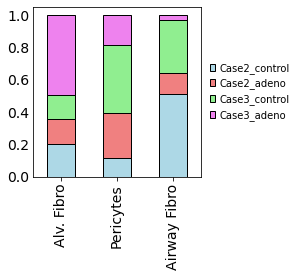

In [20]:
df=mes_sub.obs.copy()
df_plot = df.groupby(['mes_annot', 'batch']).size().reset_index().pivot(columns='batch', index='mes_annot', values=0)

# normalize rows
# Credit: https://stackoverflow.com/questions/26537878/pandas-sum-across-columns-and-divide-each-cell-from-that-value
df3 = df_plot.div(df_plot.sum(axis=1), axis=0)

order = ['Case2_control','Case2_adeno','Case3_control','Case3_adeno']
df3 = df3[order]

#df3 = df3.sort_values(by = ['0 days','14 days', '10 days'], ascending=[True, False, False])

# Manually order the rows according to time point contributions
#df3 = df3.reindex(['2','15','9','8','10','7','11','4','1','12','5','14','3','6','0','13'])

# plot

color = ['lightblue','lightcoral','lightgreen','violet']

rcParams['figure.figsize'] = 3,3
with axes_style({'axes.grid': False}):
    ax = df3.plot(kind='bar', stacked=True, edgecolor='black', color = color
                 )
    ax.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1, frameon=False, title='', 
    title_fontsize=10, fontsize=10)
    ax.set_xlabel("", rotation=0, labelpad=10, fontsize=10)
    ax.set_ylabel("", rotation=90, labelpad=10, fontsize=10)
    #ax.set_xticklabels(df3.index, fontsize=10)
    #ax.set_yticklabels([0.0,0.5,1.0], fontsize=10)
    ax.tick_params(axis=u'y', which=u'both',length=0)
    #despine(right=True, left=True)

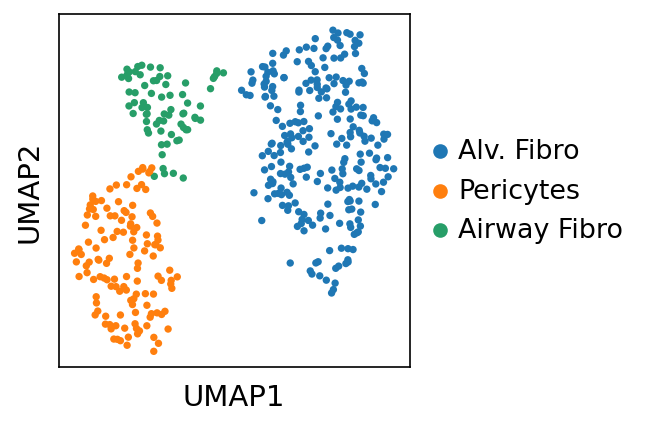

In [13]:
rcParams['figure.facecolor']='white'
rcParams['figure.figsize']=3,3
rcParams['figure.dpi']= 150
sc.pl.umap(mes_sub, color=['mes_annot'], wspace=0.6, frameon=True, legend_loc='right margin', add_outline=False, s=50, title='')

In [7]:
len(mes_sub.obs.index)

454

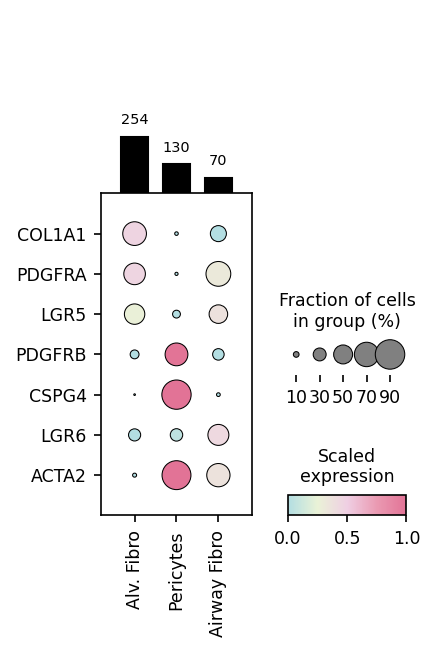

In [11]:
genes = ['COL1A1','PDGFRA','LGR5','PDGFRB','CSPG4',"LGR6",'ACTA2']

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", np.flip(['#e27396', '#ea9ab2', '#efcfe3', '#eaf2d7', '#b3dee2']))

scaled = sc.pp.scale(mes_sub, copy=True)

rcParams['figure.dpi'] = 150
dp = sc.pl.dotplot(scaled, var_names=genes, groupby = 'mes_annot', use_raw=False, vmin=0, vmax=1,
             colorbar_title='Scaled\nexpression', swap_axes=True, return_fig=True)
dp.add_totals(color='black').style(dot_edge_color='black', dot_edge_lw=0.5, cmap=cmap).show()